In [3]:
import json, re, shutil, os, pprint, logging, pickle
import pandas as pd
import polars as pl

from utils.Utils import *

In [4]:
# Paths
adult_oscar_dir = "/netscratch/fonseca/oscar-pre-processing/data/processed/adult-oscar"

# Matches the language abreviation at start of filename
regex = "(?<=\/)[a-z]{2,3}(?=_)|$"

europe_languages = ["Dutch", "French", "German", "Italian", "Danish", "English",
"Greek", "Portuguese", "Spanish", "Finnish", "Swedish", "Czech", "Estonian",
"Hungarian", "Latvian", "Lithuanian", "Maltese", "Polish", "Slovak", "Slovenian",
"Bulgarian", "Irish", "Romanian", "Croatian"]

# reverse key for lg:language equivalence
lg_dict = {v:k for k,v in lang_dict.items()}


pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


def filter_std(df,stds = 1.5):
    df_list = []
    for col in df:
        std = df[col].std()
        mean = df[col].mean()
        # lower = mean - 1.5*std
        upper = mean + 1.5*std
        df_list.append(df.loc[(df[col] <= upper)][col])
            # df_list.append(df.loc[(df[col] >= lower) & (df[col] <= upper)][col])
    return pd.concat(df_list,axis=1)

# UD Perplexities

In [5]:
df = pd.read_json('./results/pps/pt_pp_docs.json')
df.head()

,doc_id,pp_score,language
0,./filter_ud/UD_Portuguese-PetroGold/UD_Portuguese-PetroGold-concat.txt,8570,Portuguese
1,./filter_ud/UD_Portuguese-Bosque/UD_Portuguese-Bosque-concat.txt,4580,Portuguese
2,./filter_ud/UD_Portuguese-CINTIL/UD_Portuguese-CINTIL-concat.txt,7679,Portuguese
3,./filter_ud/UD_Portuguese-PUD/UD_Portuguese-PUD-concat.txt,3911,Portuguese
4,./filter_ud/UD_Portuguese-GSD/UD_Portuguese-GSD-concat.txt,3271,Portuguese


# Adult corpus perplexity

# Example

This session loads and recovers the perplexity for one of the jsonl files created
for the oscar-corpus containing only adult content

In [6]:
dfpl = pl.read_ndjson(adult_oscar_dir + "/pt_meta/pt_meta_part_1.jsonl")

In [7]:
dfpl.head()

content,warc_headers,metadata
str,struct[9],struct[6]
"""Curta os Video…","{""<urn:uuid:c3cdf787-10cf-4502-9416-87e683de9577>"",""sha1:SRE3EEUCJWLRVFUOX5NNEQEHTEBBHI4D"",""2022-11-29T00:58:28Z"",""https://salvandosuabronha.com/boquete-sexo/"",""<urn:uuid:30e9dd23-91c5-4a4e-89f6-6438160d8a04>"",""conversion"",""text/plain"",""632"",""por""}","{{""pt"",0.982402},570.64935,""tlsh:T1AACC5DF0DD49C5C00EFE191BCE5B02301C4339C7ABE7EAE0A38B276AE0B82EF11BA616BF802412D301909A10208D7F84C41277CC88936648C991B92B4B0520C4205BB369D2"",[""tiny""],[""porn"", ""adult""],[{""pt"",0.9824022}]}"
"""Comendo Entead…","{""<urn:uuid:48a2d3ff-2ac2-4e67-a31e-a9b6349d00c6>"",""sha1:OUDV6VSEID3POYYNPHWJFX55CSLNSDDQ"",""2022-11-29T00:17:15Z"",""https://www.xvideos-tv.com/comendo-enteada/"",""<urn:uuid:b2bbe819-3e66-4d2e-b6d6-289ad4af243a>"",""conversion"",""text/plain"",""1883"",""por""}","{{""pt"",0.7535834},1769.4886,""tlsh:T152451D41321DBC155F6016A5DA4F97C06827FD96E6D5DFE402CA632FC0BC3EA92ED7759F720816C98163476123C47B93C283D9CDD40A521B8EC2A4E74A1630C8588D53E36E"",[""short_sentences"", ""header"", ""footer""],[""porn"", ""adult""],[{""pt"",0.9837137}, {null,null}, … {""pt"",0.9325305}]}"
"""A excomunhão d…","{""<urn:uuid:68b496c7-3aef-4cd9-a3ce-61e5c23ade0f>"",""sha1:FJB4MOLN73DHCVHWTB4XHDTYDHI6MIM4"",""2022-11-26T12:02:30Z"",""https://portugalgay.pt/news/270906A/eua_catolicismo_pouco_preocupado_em_relacao_a_excomunhao_de_padres_casados"",""<urn:uuid:018f4cb8-dbd5-4eb1-a650-b44ad63d2e56>"",""conversion"",""text/plain"",""3594"",""por""}","{{""pt"",0.78423},2884.5542,""tlsh:T12758B271A737F92C7EE18A87F66B039028BCE415EA716FCAF31F722450AA3E751AC98C35AB291F442252391303C126029793ECA9C68CFE99C1E6ED7B580712DC9499569F50"",[""footer""],[""porn"", ""adult""],[{""pt"",0.9929545}, {""pt"",0.9038146}, … {null,null}]}"
"""Neste vídeo po…","{""<urn:uuid:3af3a890-1a4b-4454-9f5c-c2a2973815b0>"",""sha1:JSXYLGENYAIRBMH5JCNM46TVUA75VKM2"",""2022-12-08T07:25:33Z"",""https://favelaporno.com/marido-de-tacristinalmeida-deu-ela-para-um-negro-de-pau-grande/"",""<urn:uuid:1b4a4559-decb-4b4d-b4b9-83fd5f46e3dc>"",""conversion"",""text/plain"",""2938"",""por""}","{{""pt"",0.804617},1031.9656,""tlsh:T1B994045186197E6CCFB34FC1A8678551A9F9D499B3A0AFFC6183C25A537C78E54B87604902000E8603158DA013DB278ED6939CEF85F2B513C842A2AF871223C95589DB7AB6"",[""short_sentences"", ""header"", ""footer""],[""adult"", ""porn""],[{""pt"",0.985515}, {null,null}, … {""pt"",0.9785557}]}"
"""Para criar um …","{""<urn:uuid:49528c6d-edcb-4346-8923-f39a4d465071>"",""sha1:4B6YLVZ6NF4WAID4XHCYZP7AK6MHX53Y"",""2022-12-07T10:38:06Z"",""https://fatalmodel.com/386290/alexander-386290"",""<urn:uuid:cd035221-3c13-44e1-a69c-77b79e673df5>"",""conversion"",""text/plain"",""11890"",""por""}","{{""pt"",0.8556691},1575.4915,""tlsh:T19DF4B032A5199A292FF70748991F4B514A75F6D8F0DDA594C22F6397426D7E968A78222ACB3885EA033B44330391B759C723964CC241B64DD5C7C7FE0F8C06CD981EF3EE92"",[""short_sentences"", ""header"", ""footer""],[""adult"", ""porn""],[{""pt"",0.9884776}, {""pt"",0.8932468}, … {""pt"",0.9992112}]}"


In [8]:
# filtering out the nested JSONS

harmful_pp_list = list(map(return_pp, dfpl[:,2]))

In [9]:
# recovering a small dataframe with only the relevant information for now
new_df = pl.DataFrame({'content': dfpl[:,0], 'harmful_pp':harmful_pp_list})

In [10]:
new_df.head()

content,harmful_pp
str,f64
"""Curta os Video…",570.64935
"""Comendo Entead…",1769.4886
"""A excomunhão d…",2884.5542
"""Neste vídeo po…",1031.9656
"""Para criar um …",1575.4915


In [11]:
new_df.mean()

content,harmful_pp
str,f64
null,2482.138421


# Mean Perplexity Score for Adult content in Oscar

Extracting perplexity for adult-oscar 

> If the file is already created skip to the load cells

In [12]:
logging.basicConfig(level=logging.DEBUG,filename='adult_perplexity.log')

In [ ]:
# Caution, this block takes around 15minutes to run on the batch node

# make the comparison True to run
if 1 == 0:
    # Loading Paths
    f_paths = []
    for root, dirnames, files in os.walk(adult_oscar_dir):
        for file in files:
            f_paths.append(os.path.join(root,file))

    # Reading 
    dict_means = {}
    dict_full = {}
    for path in f_paths:
        # check which language from path applying the regex
        lg = re.findall(regex,path)[0]
        # ignores path if can't find the language
        if lg == '':
            continue
        # Creates a key for the dictionary of mean perplexity for each language
        if lg not in dict_means.keys():
            dict_means[lg] = []
            dict_full[lg] = []

        # try block for reading the json from the adult corpus
        try:
            dataframe = pl.read_ndjson(path)
            # Gets the perplexity of each document as a list
            harmful_pp_list = list(map(return_pp, dataframe[:,2]))
        except RuntimeError as r:
            # Runtime errors are raised when the read_ndjson method cannot read it
            # completely (most likely requires a re run of the create_adul_ds.py for
            # this specific language)
            logging.warning("{}:\n{}".format(r ,path))
            continue
        except KeyError as k:
            logging.warning("{}:{}".format(k ,path))
            continue

        dict_full[lg].extend(harmful_pp_list)
        dict_means[lg].append(sum(harmful_pp_list)/len(harmful_pp_list))

    c_dict_means = {lg: sum(means)/len(means) for (lg,
            means) in dict_means.items() if len(means) != 0}

    c_dict_means = {lg_dict[k] : v for k,v in c_dict_means.items()}

In [5]:
# saving the perplexity 
# commented out so I don't accidentally overwrite the file

# with open('./adult_pp_dict.pkl', 'wb') as file:
#     pickle.dump(c_dict_means,file)

# with open('./adult_pp_dict_full.pkl', 'wb') as file:
#     pickle.dump(dict_full,file)

## Load the dictionary with perplexity for adult-oscar content

In [22]:
# Load dict
with open('./results/pp_mean_dicts/adult_pp_dict.pkl', 'rb') as file:
    c_dict_means = pickle.load(file)

with open('./results/pp_mean_dicts/adult_pp_dict_full.pkl', 'rb') as file:
    dict_full = pickle.load(file)

# a list of EU languages abbreviation
eu_lg = [lang_dict[l] for l in europe_languages]

# filtering the mean perplexity for official EU languages 
eu_pps = {key:value for key,value in c_dict_means.items() if key in europe_languages}

In [25]:
# Dictionary with mean perplexity by language for documents with the "adult" tag in oscar
eu_pps

{'Slovak': 11482.729111494735,
 'English': 1321.848530311227,
 'German': 3865.0844278517334,
 'Romanian': 3289.5020744583003,
 'Greek': 9700.148223445325,
 'Swedish': 6507.748918533279,
 'Bulgarian': 6477.285412765637,
 'Czech': 18454.28785890177,
 'Estonian': 5254.884522946542,
 'Hungarian': 13742.707306890257,
 'Polish': 10504.465567390756,
 'Danish': 3446.3530769948893,
 'Portuguese': 2551.497857495963,
 'Finnish': 10096.609868553292,
 'Latvian': 4375.965811636749,
 'Slovenian': 1855.1647045403718,
 'French': 1828.8094992694703,
 'Lithuanian': 32722.90585405496,
 'Dutch': 1951.7184170565697,
 'Italian': 4912.9487112597,
 'Spanish': 3194.186531106972}

# Perplexities from UD

In [35]:
# Reading the paths

f_paths = []
for root, dirnames, files in os.walk("./results/pps/"):
    for file in files:
        # the "pps" folder contain perplexity scores by document (doc) and by line (line)
        # this is recognized by the file name. Here we select mean perplexity scores by document
        if "docs" in file:
            f_paths.append(os.path.join(root,file))

# Create dataframes with all files, and concatenate them
dfs = [pd.read_json(path) for path in f_paths]
all_ud_pps = pd.concat(dfs, ignore_index=True)
all_ud_pps.rename(columns={'pp_score':'ud_pp_score'},inplace=True)
all_ud_pps

,doc_id,ud_pp_score,language
0,./filter_ud/UD_Polish-PUD/UD_Polish-PUD-concat.txt,30024.00,Polish
1,./filter_ud/UD_Polish-PDB/UD_Polish-PDB-concat.txt,22374.00,Polish
2,./filter_ud/UD_Polish-LFG/UD_Polish-LFG-concat.txt,23359.00,Polish
3,./filter_ud/UD_Estonian-EWT/UD_Estonian-EWT-concat.txt,6450.00,Estonian
4,./filter_ud/UD_Estonian-EDT/UD_Estonian-EDT-concat.txt,8239.00,Estonian
...,...,...,...
73,./filter_ud/UD_Czech-FicTree/UD_Czech-FicTree-concat.txt,16582.00,Czech
74,./filter_ud/UD_Czech-PDT/UD_Czech-PDT-concat.txt,29044.00,Czech
75,./filter_ud/UD_Czech-PUD/UD_Czech-PUD-concat.txt,25107.00,Czech
76,./filter_ud/UD_Czech-CLTT/UD_Czech-CLTT-concat.txt,48331.00,Czech


In [37]:
print(all_ud_pps.head())

                                                   doc_id  ud_pp_score  \
0      ./filter_ud/UD_Polish-PUD/UD_Polish-PUD-concat.txt     30024.00   
1      ./filter_ud/UD_Polish-PDB/UD_Polish-PDB-concat.txt     22374.00   
2      ./filter_ud/UD_Polish-LFG/UD_Polish-LFG-concat.txt     23359.00   
3  ./filter_ud/UD_Estonian-EWT/UD_Estonian-EWT-concat.txt      6450.00   
4  ./filter_ud/UD_Estonian-EDT/UD_Estonian-EDT-concat.txt      8239.00   

   language  
0    Polish  
1    Polish  
2    Polish  
3  Estonian  
4  Estonian  


In [38]:
print(all_ud_pps.groupby('language').mean())

            ud_pp_score
language               
Bulgarian       8211.00
Czech          29051.00
Danish          3886.00
Dutch          38684.67
English         2821.00
Estonian        7344.50
Finnish        33856.50
French         16399.22
German         90960.83
Greek         160233.67
Hungarian      20491.00
Italian         5407.00
Latvian        16630.00
Lithuanian     69717.00
Polish         25252.33
Portuguese      5602.20
Romanian       24557.00
Slovak         32766.00
Slovenian       3304.50
Spanish         2492.67
Swedish         9553.33


## Score analysis

Some values are incredibly high, so after some investigation, either by 
reading into the documents or the documentation, some documents were removed

> frisian dutch is not the dominant variety, therefor score is wrong  
- 6   ./new_/UD_Frisian_Dutch-Fame/UD_Frisian_Dutch-...   96960.0       Dutch  

> Each document contains a twitter link   
- 11  ./new_/UD_Italian-PoSTWITA/UD_Italian-PoSTWITA...   12160.0     Italian  
- 12  ./new_/UD_Italian-TWITTIRO/UD_Italian-TWITTIRO...   11627.0     Italian  

> Empty files  
- 32  ./new_/UD_English-GUMReddit/UD_English-GUMRedd...      78.0     English  
- 33  ./new_/UD_Hindi_English-HIENCS/UD_Hindi_Englis...       5.0     English  
- 38    ./new_/UD_English-ESL/UD_English-ESL-concat.txt       7.0     English  

> contains only pronouns  
- 40  ./new_/UD_English-Pronouns/UD_English-Pronouns...   10955.0     English  

> Non standard varieties or different writing systems  
- 42  ./filter_ud/UD_Romanian-ArT/UD_Romanian-ArT-co...   68409.0    Romanian  
- 43  ./filter_ud/UD_Romanian-Nonstandard/UD_Romania...   15181.0    Romanian  

> These files contain ancient greek, not modern greek   
- 46  ./new_/UD_Ancient_Greek-PROIEL/UD_Ancient_Gree...  231697.0       Greek  
- 48  ./new_/UD_Ancient_Greek-Perseus/UD_Ancient_Gre...  243466.0       Greek   

> multilingual treebank  
- 50  ./new_/UD_Turkish_German-SAGT/UD_Turkish_Germa...   67073.0      German    

> Swiss german  
- 53  ./filter_ud/UD_Swiss_German-UZH/UD_Swiss_Germa...  432958.0      German  

> Old french  
- 60  ./filter_ud/UD_Old_French-SRCMF/UD_Old_French-...  127478.0      French  

> Has missing words  
- 68  ./filter_ud/UD_French-FTB/UD_French-FTB-concat...     591.0      French  


In [39]:
# Removing rows by index

all_ud_pps_filter = all_ud_pps.drop(index=[6,11,12,32,33,38,40,42,43,46,48,50
            ,53,60,68])
            
print(all_ud_pps_filter.groupby('language').mean())

            ud_pp_score
language               
Bulgarian       8211.00
Czech          29051.00
Danish          3886.00
Dutch           9550.50
English         2835.67
Estonian        7344.50
Finnish        33856.50
French          2789.14
German         11425.50
Greek           5417.00
Hungarian      20491.00
Italian         3652.00
Latvian        16630.00
Lithuanian     69717.00
Polish         25252.33
Portuguese      5602.20
Romanian        7319.00
Slovak         32766.00
Slovenian       3304.50
Spanish         2492.67
Swedish         9553.33


In [40]:
# Saving the UD perplexities as a dict to a file

temp_dict = all_ud_pps_filter.groupby('language').mean().T.to_dict()
pp_ud_dict = {k:v['ud_pp_score'] for k,v in temp_dict.items() }

# with open('./ud_pp_dict.pkl', 'wb') as file:
#     pickle.dump(pp_ud_dict,file)

In [43]:
# Creating a dataframe to compare perplexities

final_df = all_ud_pps_filter.groupby('language').mean().reset_index()
final_df['adult_pp'] = final_df['language'].map(eu_pps)

final_df.adult_pp = final_df.adult_pp.round(2)
final_df.ud_pp_score = final_df.ud_pp_score.round(2)
final_df

,language,ud_pp_score,adult_pp
0,Bulgarian,8211.00,6477.29
1,Czech,29051.00,18454.29
2,Danish,3886.00,3446.35
3,Dutch,9550.50,1951.72
4,English,2835.67,1321.85
5,Estonian,7344.50,5254.88
6,Finnish,33856.50,10096.61
7,French,2789.14,1828.81
8,German,11425.50,3865.08
9,Greek,5417.00,9700.15


## Filtering

Since the mean perplexity for **adult-oscar** might seem too high, some filtereing methods were created to check for the
data behavior

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={"figure.figsize":(16, 9)}) #width=6, height=5


In [45]:
# a list of EU languages in their abbreviated form
eu_lg = [lang_dict[l] for l in europe_languages]

# Similar to dict_full, which has the perplexity values for each document in adult oscar
# but this one has only perplexity values for EU languages
dict_full_2 = {lg_dict[key]:value for key,value in dict_full.items() if key in eu_lg}


# Turning dictionary into dataframe
df = pd.DataFrame.from_dict(dict_full_2, orient='index').T
df.head()


,Slovak,English,German,Romanian,Greek,Swedish,Bulgarian,Czech,Estonian,Hungarian,Polish,Danish,Portuguese,Finnish,Latvian,Slovenian,French,Irish,Lithuanian,Dutch,Italian,Spanish,Croatian,Maltese
0,9264.43,4.35,338.26,1933.52,16006.79,1213.78,8747.10,158.03,6325.18,22171.46,2549.34,2905.22,570.65,8843.87,237.43,4834.84,418.33,NaN,16462.06,965.05,5105.34,344.38,NaN,NaN
1,18595.86,568.50,2384.09,2024.54,10.67,4711.57,94853.35,158.03,6325.18,1.24,15.24,5196.00,1769.49,39011.16,392.07,1492.76,1638.30,NaN,104893.39,332.27,8.37,482.98,NaN,NaN
2,31505.19,1.93,138.42,3126.96,8817.51,54710.78,3487.90,23136.00,6325.18,22642.44,172.23,4217.84,2884.55,8843.87,9355.84,1673.12,1534.66,NaN,4.40,316.96,8091.26,3605.35,NaN,NaN
3,21800.10,1.58,6187.87,5560.05,2895.34,1213.78,7.05,10989.78,6325.18,24443.19,12243.04,569.94,1031.97,8843.87,6.81,1883.45,220.07,NaN,130122.59,487.01,1.42,170.52,NaN,NaN
4,2620.13,1.55,6110.25,19.45,14437.79,4.22,7003.15,23136.00,1.71,6.36,29322.81,5667.52,1575.49,8843.87,3.10,2643.61,3132.87,NaN,74880.82,2111.72,6253.19,770.74,NaN,NaN


In [46]:
# saving this dataframe to a csv
df.to_csv('./pp_score_adult_oscar.csv',index=False)

In [47]:
# Loading the dataframe
df = pd.read_csv('./pp_score_adult_oscar.csv')

In [48]:
df.describe()

,Slovak,English,German,Romanian,Greek,Swedish,Bulgarian,Czech,Estonian,Hungarian,Polish,Danish,Portuguese,Finnish,Latvian,Slovenian,French,Irish,Lithuanian,Dutch,Italian,Spanish,Croatian,Maltese
count,1639.00,2492141.00,162259.00,3132.00,6268.00,3320.00,3298.00,24076.00,1153.00,17575.00,18089.00,5379.00,62536.00,5164.00,596.00,161.00,245352.00,0.00,919.00,38204.00,37825.00,91382.00,0.00,0.00
mean,11482.73,1339.17,3962.46,3289.50,9919.35,6507.75,6477.29,18761.63,5254.88,13741.92,10302.27,3446.35,2522.41,10096.61,4375.97,1855.16,1828.62,NaN,32722.91,1954.22,4970.09,3190.79,NaN,NaN
std,12584.51,46748.57,23249.60,4901.84,14906.28,14360.18,8280.53,21740.76,2041.03,14636.00,19949.64,2615.18,25971.87,8245.76,6090.38,993.27,15190.17,NaN,27250.10,7264.82,25082.20,19163.72,NaN,NaN
min,1.51,1.08,1.09,1.22,1.42,1.84,3.52,1.24,1.71,1.11,1.14,1.29,1.29,1.21,1.48,3.73,1.06,NaN,1.16,1.14,1.12,1.17,NaN,NaN
25%,3560.84,8.66,273.54,1368.43,338.04,30.79,2014.25,7744.03,4777.77,4335.47,444.33,1385.68,289.81,5720.14,21.31,1408.36,248.28,NaN,16462.06,75.85,440.47,292.87,NaN,NaN
50%,8481.41,277.08,1586.93,2202.59,4226.81,1728.41,3260.06,16758.97,6325.18,10495.51,6467.08,3165.67,938.12,8843.87,810.41,2114.37,548.00,NaN,26045.11,612.03,1916.62,890.16,NaN,NaN
75%,16697.51,837.77,4536.51,3751.12,13232.47,5613.24,8623.61,25014.31,6325.18,20120.88,10361.90,4712.16,2173.23,11543.43,6792.65,2463.78,1338.27,NaN,40923.26,2012.37,4538.58,2093.66,NaN,NaN
max,230507.83,32766206.00,3074749.00,71312.34,85136.20,266686.22,119018.76,385787.00,12609.71,253087.52,602219.25,36958.53,2521339.80,89794.15,34327.35,4834.84,3249432.00,NaN,182316.95,974687.44,1183967.90,801921.56,NaN,NaN


## Filtering out the top5 percent of measurements

In [11]:
# Filtering the perplexity scores from the adult version os Oscar.
# Filtering is done by removing the top 5% scores

list_ = []
for col in df:
    list_.append(df[col][df[col] < df[col].quantile(0.95)])
filter_df = pd.concat(list_, axis=1)

filter_df.describe()

,Slovak,English,German,Romanian,Greek,Swedish,Bulgarian,Czech,Estonian,Hungarian,Polish,Danish,Portuguese,Finnish,Latvian,Slovenian,French,Irish,Lithuanian,Dutch,Italian,Spanish,Croatian,Maltese
count,1557.00,2367533.00,154146.00,2975.00,5954.00,3150.00,3133.00,22872.00,327.00,16695.00,17184.00,5109.00,59409.00,4905.00,566.00,152.00,233084.00,0.00,873.00,36293.00,35933.00,86812.00,0.00,0.00
mean,9584.42,485.25,2496.42,2469.02,7307.85,3916.29,5192.98,15679.65,2482.62,11648.51,7109.80,3066.68,1403.98,8758.93,3455.88,1758.95,889.99,NaN,28416.43,1212.23,2656.20,1336.19,NaN,NaN
std,7658.20,643.92,2850.28,1874.66,9651.97,6221.79,4671.78,10693.20,1941.01,9241.46,8398.46,1899.43,1545.16,5638.10,4574.22,927.60,1038.33,NaN,19617.76,1511.95,2848.21,1440.05,NaN,NaN
min,1.51,1.08,1.09,1.22,1.42,1.84,3.52,1.24,1.71,1.11,1.14,1.29,1.29,1.21,1.48,3.73,1.06,NaN,1.16,1.14,1.12,1.17,NaN,NaN
25%,3302.82,7.36,216.42,1316.41,327.19,14.12,1944.36,6898.48,424.19,3750.51,335.89,1322.63,261.39,5720.14,10.63,1371.14,237.46,NaN,16462.06,49.31,323.39,269.59,NaN,NaN
50%,7372.31,228.45,1414.12,2118.96,3728.99,1521.24,3152.87,15897.60,2370.35,9648.47,5319.25,3098.17,847.26,8843.87,569.56,2033.58,513.88,NaN,24114.19,525.33,1722.49,849.98,NaN,NaN
75%,14899.46,713.02,3946.09,3322.23,11269.34,4773.13,7392.55,23327.79,4314.16,17712.42,10234.95,4425.17,1866.52,9268.15,5889.42,2412.19,1142.86,NaN,38744.46,1845.82,3905.59,1779.28,NaN,NaN
max,30243.75,3174.48,11857.27,9542.45,52684.29,42840.69,18363.04,38945.60,6296.94,33644.46,39925.96,7947.33,7464.42,26775.65,16326.50,2942.75,5628.15,NaN,85391.59,7174.67,12811.84,6665.34,NaN,NaN


In [17]:
# This cell saves the mean to a pkl file, so I can use it later on another script

with open('./results/pp_mean_dicts/pp_score_adult_oscar_filt_minus_top5p.pkl', 'wb') as file:
    pickle.dump(filter_df.mean().to_dict(),file)

## Filtering out measurements that are 1.5 std above the mean

In [6]:
# Filtering the perplexity scores from the adult version os Oscar.
# Filtering is done by removing scores above 1.5 standard deviations above the mean
# Using function described in start of script


filter_std_df = filter_std(df)

filter_std_df.describe()

,Slovak,English,German,Romanian,Greek,Swedish,Bulgarian,Czech,Estonian,Hungarian,Polish,Danish,Portuguese,Finnish,Latvian,Slovenian,French,Irish,Lithuanian,Dutch,Italian,Spanish,Croatian,Maltese
count,1557.00,2488845.00,161500.00,2999.00,5788.00,3104.00,3148.00,23487.00,1150.00,16894.00,17196.00,5039.00,62387.00,4749.00,533.00,156.00,242704.00,0.00,837.00,37376.00,37522.00,90515.00,0.00,0.00
mean,9584.42,905.46,3173.81,2530.34,6110.03,3437.24,5257.19,16409.25,5242.33,11918.69,7132.82,3003.18,1947.14,8248.41,2740.75,1791.73,1276.78,NaN,26165.88,1445.59,3416.04,1703.40,NaN,NaN
std,7658.20,3157.22,4346.40,1988.26,6621.85,4811.64,4752.17,11465.82,2026.72,9514.59,8440.59,1833.92,3163.56,4958.08,3659.37,937.75,2333.58,NaN,16666.52,2027.93,4779.33,2463.04,NaN,NaN
min,1.51,1.08,1.09,1.22,1.42,1.84,3.52,1.24,1.71,1.11,1.14,1.29,1.29,1.21,1.48,3.73,1.06,NaN,1.16,1.14,1.12,1.17,NaN,NaN
25%,3302.82,8.66,266.68,1320.30,322.75,14.12,1950.41,7388.19,4770.28,3980.49,338.12,1311.40,288.65,5288.61,9.50,1373.83,245.60,NaN,16462.06,67.15,416.44,292.87,NaN,NaN
50%,7372.31,275.82,1568.00,2130.03,3503.97,1460.09,3160.25,16237.17,6325.18,9827.22,5330.80,3098.17,936.51,8843.87,569.56,2067.25,539.01,NaN,20875.20,578.10,1881.51,874.18,NaN,NaN
75%,14899.46,835.62,4487.58,3369.22,10314.67,4588.22,7447.43,24184.59,6325.18,18249.61,10234.95,4357.93,2153.19,9268.15,5311.02,2432.19,1288.17,NaN,36699.45,1904.28,4444.00,2023.76,NaN,NaN
max,30243.75,71421.10,38740.08,10585.97,31885.38,27330.82,18897.65,51315.32,8124.11,35678.16,40212.63,7363.74,41283.73,22447.41,13217.39,3087.14,24606.80,NaN,73473.60,12842.25,42326.20,31816.90,NaN,NaN


In [7]:
# Saving as a dict

with open('./pp_score_adult_oscar_filt_minus_std15.pkl', 'wb') as file:
    pickle.dump(filter_std_df.mean().to_dict(),file)

## UD perplexity per line

In [21]:
# Reading the paths

f_paths = []
for root, dirnames, files in os.walk("./pps_lines_test/"):
    for file in files:
        if "lines" in file:
            f_paths.append(os.path.join(root,file))

line_dfs = [pd.read_json(path,lines=True) for path in f_paths]
line_ud_pps = pd.concat(line_dfs, ignore_index=True)


In [22]:
line_ud_pps.head()

,doc_id,doc_lines,line_score,language
0,./filter_ud/UD_Portuguese-PetroGold/UD_Portuguese-PetroGold-concat.txt,1. - INTRODUÇÃO A Bacia de Pelotas é a mais meridional na costa brasileira\n,4869,Portuguese
1,./filter_ud/UD_Portuguese-PetroGold/UD_Portuguese-PetroGold-concat.txt,(Figura 1) e apresenta poucos trabalhos publicados a seu respeito se comparada\n,7299,Portuguese
2,./filter_ud/UD_Portuguese-PetroGold/UD_Portuguese-PetroGold-concat.txt,às outras bacias de margem continental brasileiras. A caracterização estrutural\n,19586,Portuguese
3,./filter_ud/UD_Portuguese-PetroGold/UD_Portuguese-PetroGold-concat.txt,para a porção norte da Bacia de Pelotas foi realizada através de 17 seções\n,2488,Portuguese
4,./filter_ud/UD_Portuguese-PetroGold/UD_Portuguese-PetroGold-concat.txt,"sísmicas, onde foram caracterizadas falhas normais, em padrão dominó, falhas\n",109566,Portuguese


In [23]:
# Dropping the same treebanks dropped for the docs perplexity

dropped_treebanks_line_ud_pps = line_ud_pps[~line_ud_pps.doc_id.str.contains('UD_Frisian_Dutch-Fame')]

treebanks_to_drop = ['UD_Italian-PoSTWITA','UD_Frisian_Dutch-Fame','UD_Italian-TWITTIRO'
,'UD_English-GUMReddit','UD_Hindi_English-HIENCS',"UD_English-ESL",'UD_English-Pronouns',
'UD_Romanian-ArT','UD_Romanian-Nonstandard','UD_Ancient_Greek-PROIEL','UD_Ancient_Greek-Perseus',
'UD_Turkish_German-SAGT','UD_Swiss_German-UZH','UD_Old_French-SRCMF','UD_French-FTB']

# dropped_treebanks_line_ud_pps = line_ud_pps[~line_ud_pps['doc_id'].isin(treebanks_to_drop)]

for i in treebanks_to_drop:
    dropped_treebanks_line_ud_pps = dropped_treebanks_line_ud_pps[~dropped_treebanks_line_ud_pps.doc_id.str.contains(i)]



In [26]:
#  final_line_ud_pps = dropped_treebanks_line_ud_pps.groupby('language').mean()

df_list = []
for language in europe_languages:
    i = dropped_treebanks_line_ud_pps.loc[dropped_treebanks_line_ud_pps['language'] == language]["line_score"]
    i.name = language
    i = i.reset_index(drop=True)
    i = i.dropna()
    df_list.append(i)

final_line_ud_pps = pd.concat(df_list,axis=1)

final_line_ud_pps.describe()

,Dutch,French,German,Italian,Danish,English,Greek,Portuguese,Spanish,Finnish,Swedish,Czech,Estonian,Hungarian,Latvian,Lithuanian,Maltese,Polish,Slovak,Slovenian,Bulgarian,Irish,Romanian,Croatian
count,22357.00,41044.00,323091.00,48865.00,6869.00,46134.00,4862.00,85101.00,68812.00,37329.00,16251.00,177723.00,43397.00,3549.00,24482.00,6359.00,0.00,37327.00,7409.00,22149.00,11182.00,0.00,27282.00,0.00
mean,58380.46,1095422.15,283506.50,468535.06,12008.30,585495758.53,127283.79,605825.47,1717817.98,85133.58,105194144.02,2438949.87,11573.79,68948.98,192984.32,449298.71,NaN,66357.92,115829.76,19554.84,240961.03,NaN,22292.95,NaN
std,3147278.38,47309416.63,17429858.82,23078310.01,296323.11,7614804766.78,2025650.12,33822407.55,42011562.44,612639.58,913488092.15,19867003.35,31572.61,1467326.05,975678.63,4303669.48,NaN,136983.49,3642230.53,110771.76,4496000.19,NaN,317328.20,NaN
min,106.00,16.00,32.00,12.00,99.00,9.00,191.00,25.00,8.00,361.00,67.00,66.00,478.00,440.00,742.00,147.00,NaN,131.00,248.00,314.00,81.00,NaN,77.00,NaN
25%,3048.00,1398.00,4849.50,1802.00,2043.00,878.25,2812.25,2456.00,1095.00,17665.00,3923.00,13649.50,5642.00,10506.00,11255.25,37815.00,NaN,10365.00,15314.00,2386.00,4039.25,NaN,3641.25,NaN
50%,7506.00,3595.00,11135.00,4573.00,4253.00,2589.00,5709.00,6019.00,2627.00,34644.00,10836.00,33108.00,8617.00,22405.00,18984.00,80590.00,NaN,25730.00,36686.00,3712.00,8983.00,NaN,7876.50,NaN
75%,21001.00,10117.50,26881.50,12344.00,9020.00,9527.00,11849.25,15077.00,6904.25,67820.00,33923.50,84538.00,12679.00,50367.00,32957.50,162442.50,NaN,65021.00,83577.00,5928.00,20084.75,NaN,16900.50,NaN
max,470008583.00,2702012508.00,1274455703.00,1468648280.00,24535253.00,103353942868.00,37561035.00,2179907342.00,1127051546.00,12283121.00,8551534049.00,186441719.00,643754.00,87267522.00,6224980.00,61195611.00,NaN,4094673.00,313424434.00,921626.00,98008958.00,NaN,14450965.00,NaN


In [25]:
list_ = []
for col in final_line_ud_pps:
    list_.append(final_line_ud_pps[col][final_line_ud_pps[col] < final_line_ud_pps[col].quantile(0.95)])
ffiltered_line_ud_pps = pd.concat(list_, axis=1)

ffiltered_line_ud_pps.describe()

,Dutch,French,German,Italian,Danish,English,Greek,Portuguese,Spanish,Finnish,Swedish,Czech,Estonian,Hungarian,Latvian,Lithuanian,Maltese,Polish,Slovak,Slovenian,Bulgarian,Irish,Romanian,Croatian
count,21239.00,38991.00,306936.00,46421.00,6525.00,43827.00,4618.00,80845.00,65371.00,35461.00,15438.00,168836.00,41199.00,3371.00,23188.00,6041.00,0.00,35460.00,7038.00,21037.00,10622.00,0.00,25917.00,0.00
mean,15083.32,7069.07,17789.13,8461.58,5933.65,12531.18,7865.15,10028.20,4750.02,44086.12,29659.86,63228.10,9151.24,32088.21,24463.09,103426.97,NaN,42887.73,53772.11,4351.22,13079.63,NaN,10961.69,NaN
std,21102.36,9520.46,19645.11,10773.31,5595.52,37560.96,7242.10,11696.91,5974.62,36429.45,57069.65,90812.89,4704.46,31128.76,23352.68,89271.41,NaN,49715.55,54375.51,2919.34,13085.11,NaN,10407.74,NaN
min,106.00,16.00,32.00,12.00,99.00,9.00,191.00,25.00,8.00,361.00,67.00,66.00,478.00,440.00,742.00,147.00,NaN,131.00,248.00,314.00,81.00,NaN,77.00,NaN
25%,2891.50,1325.00,4623.00,1707.00,1947.00,827.50,2712.50,2328.00,1045.00,16977.00,3687.25,12966.75,5508.00,9987.00,10861.75,36038.00,NaN,9805.00,14480.75,2328.00,3849.25,NaN,3497.00,NaN
50%,6878.00,3280.00,10302.00,4188.00,3958.00,2325.00,5311.00,5531.00,2403.00,32527.00,9812.00,30397.00,8289.00,20706.00,17996.00,75152.00,NaN,23530.00,33914.00,3559.00,8301.50,NaN,7322.00,NaN
75%,17385.50,8461.50,23091.00,10405.00,8050.00,7467.50,10466.00,12946.00,5812.00,60903.00,27566.00,71477.25,11855.00,43238.00,29812.00,143253.00,NaN,55369.50,73377.25,5474.00,17482.00,NaN,14840.00,NaN
max,129108.00,54650.00,102425.00,59344.00,28363.00,405565.00,36368.00,62904.00,33968.00,171298.00,475304.00,664003.00,22078.00,157704.00,203264.00,425422.00,NaN,256854.00,261992.00,16837.00,66085.00,NaN,51271.00,NaN


## Plots

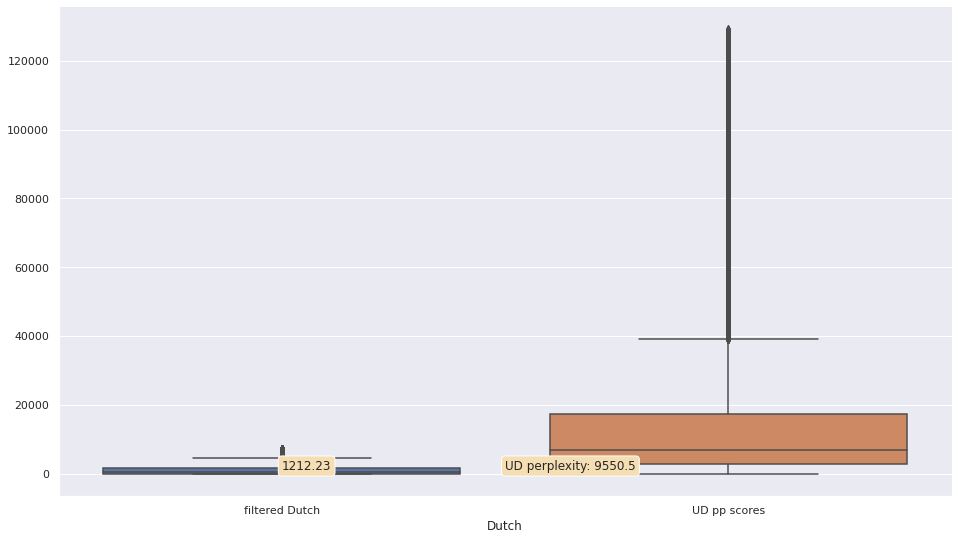

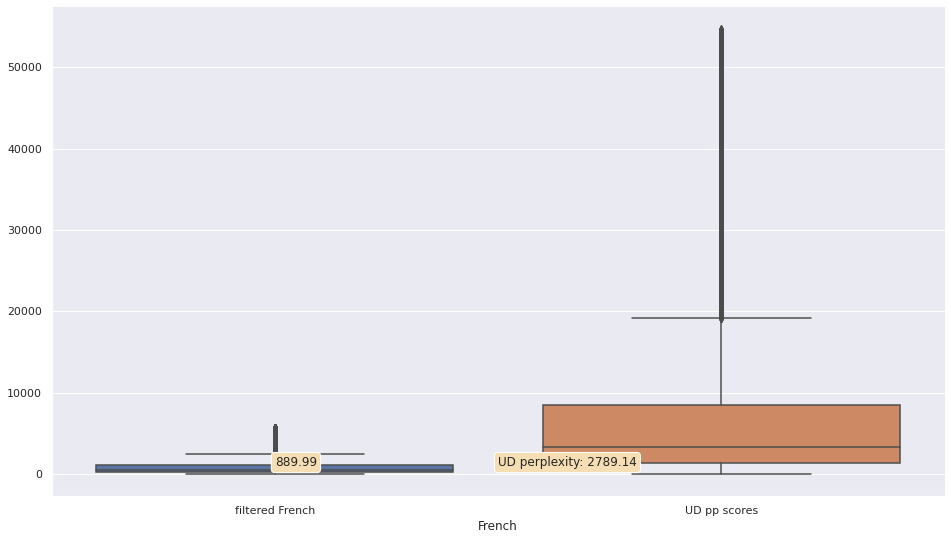

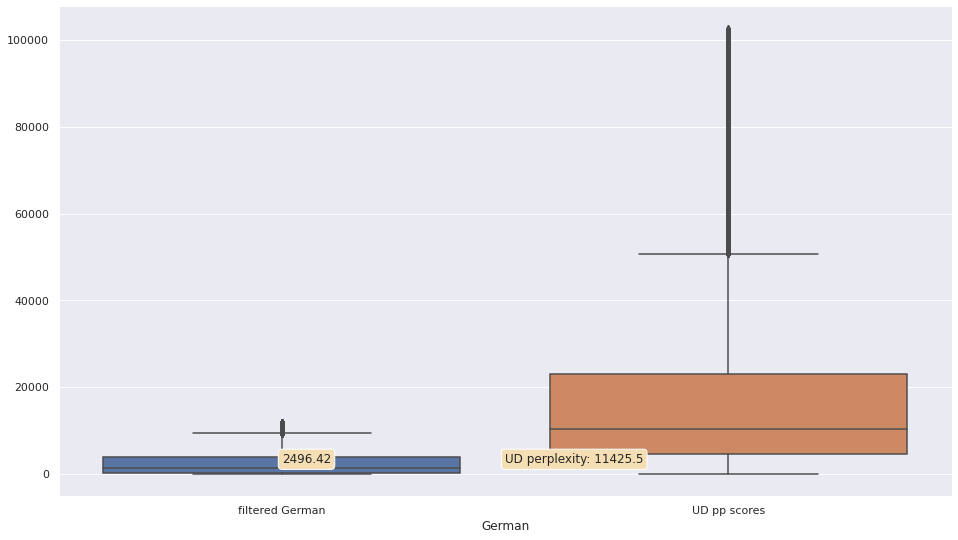

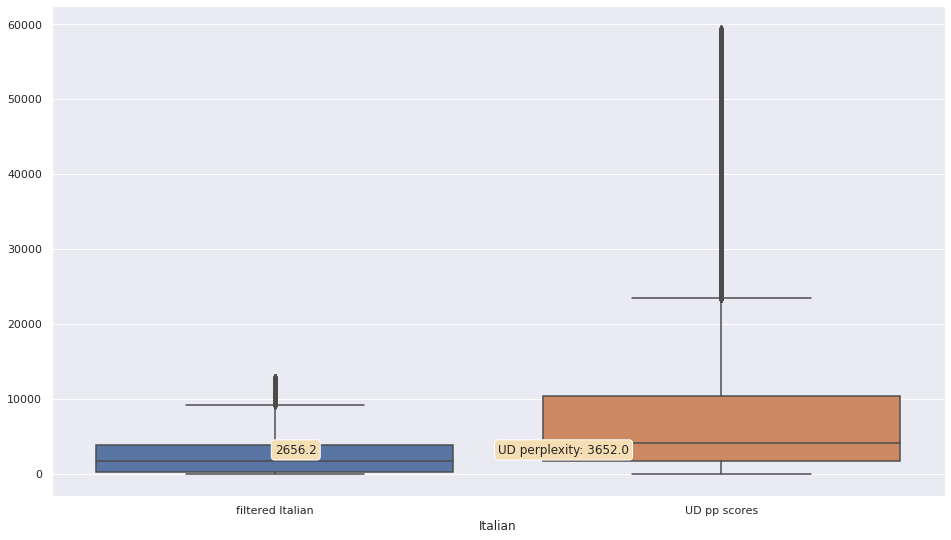

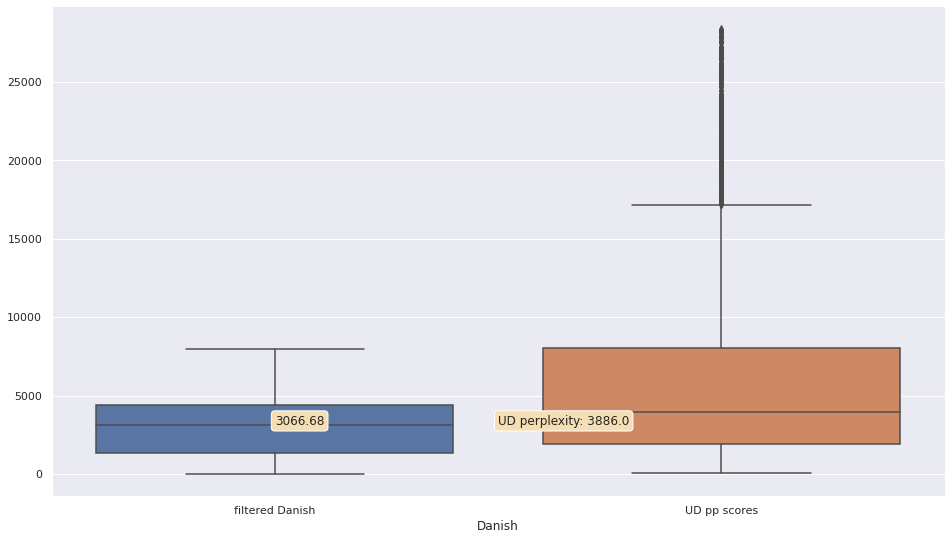

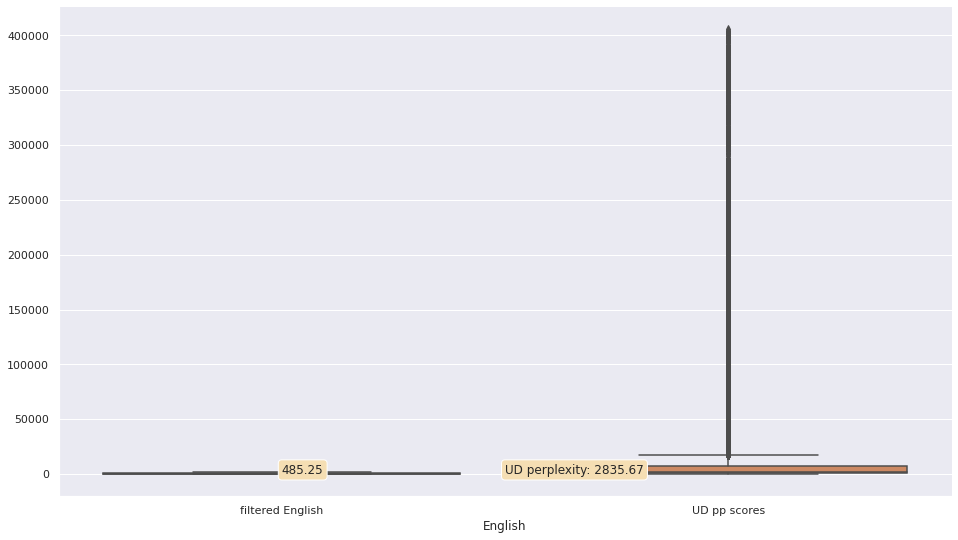

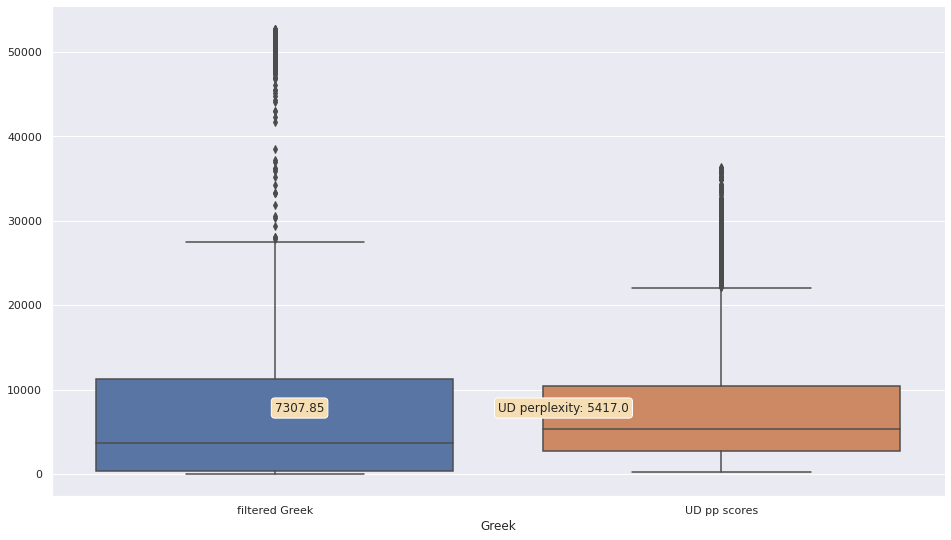

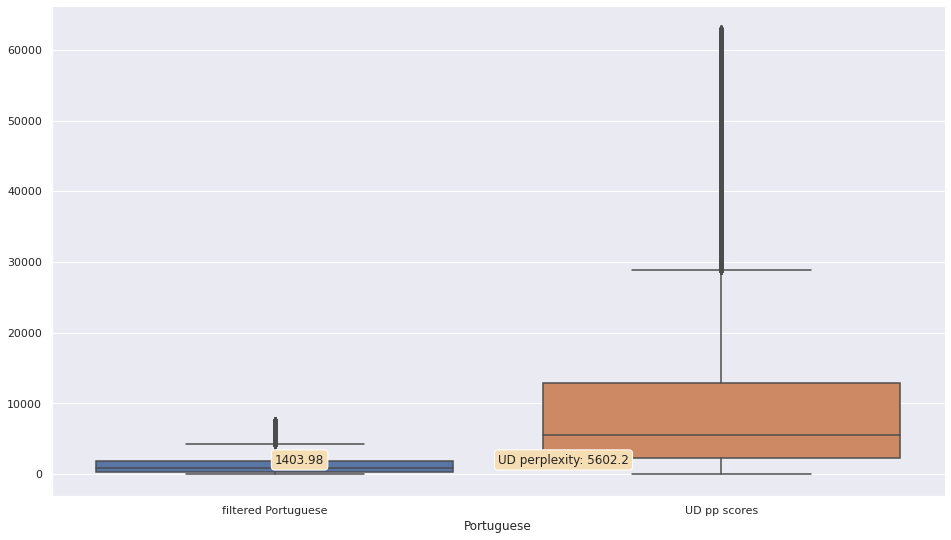

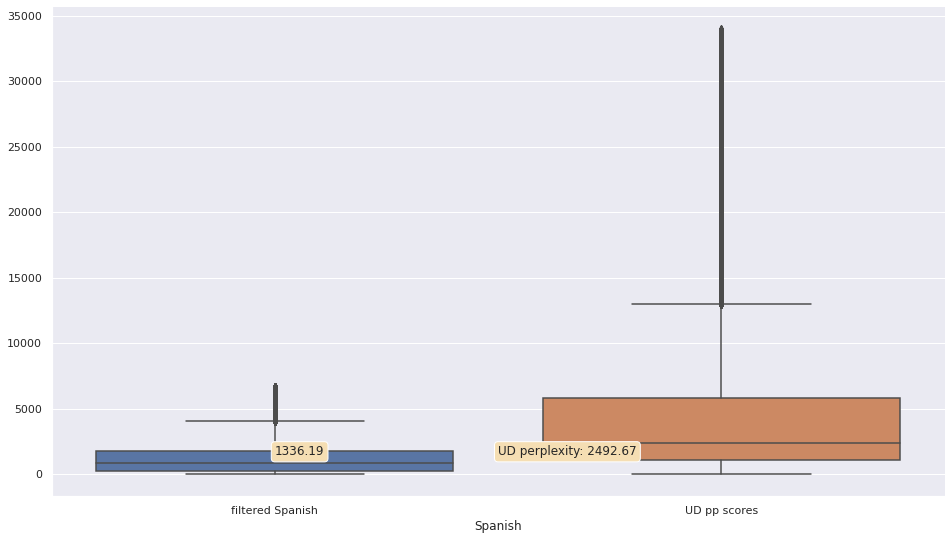

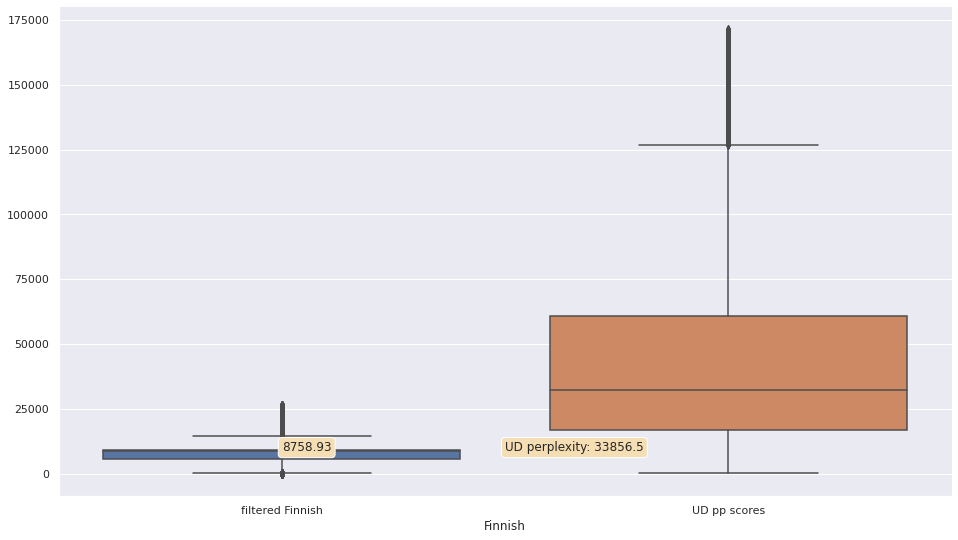

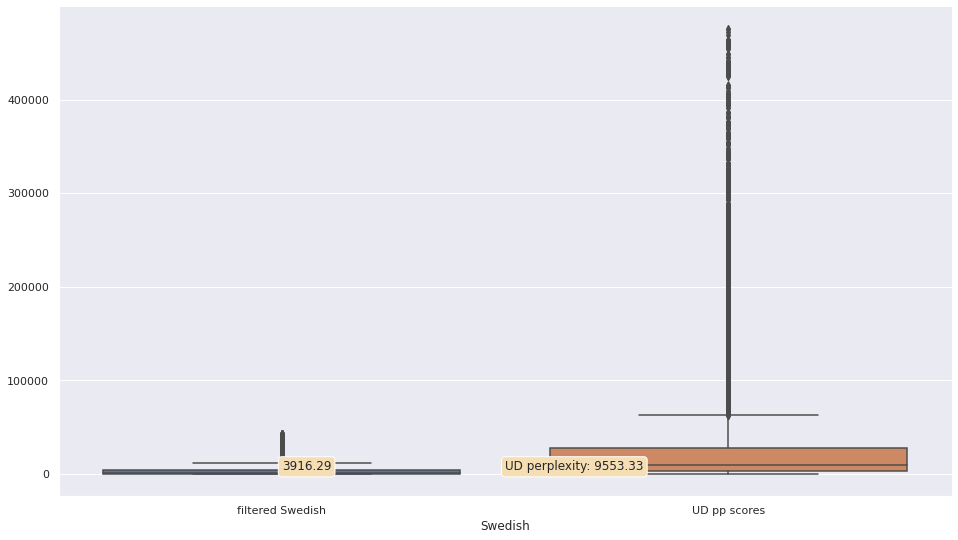

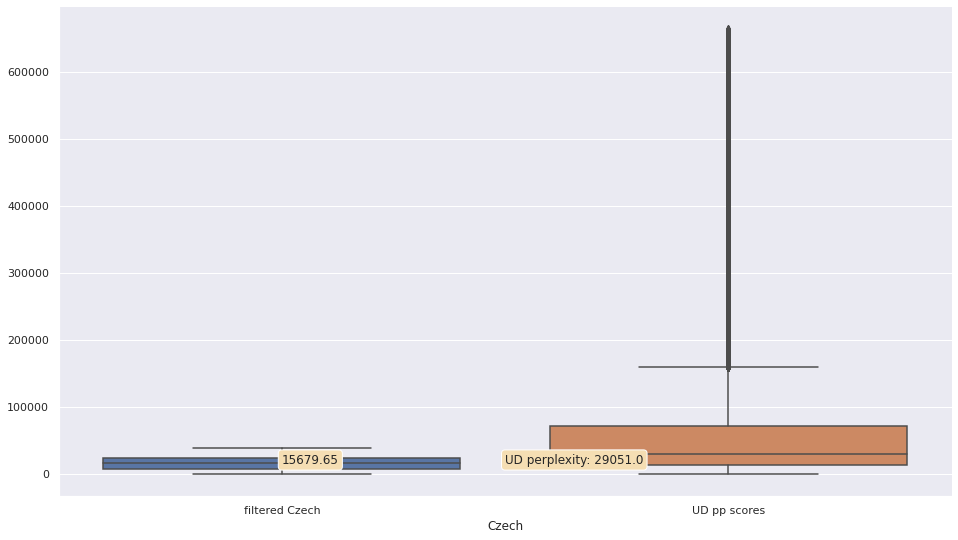

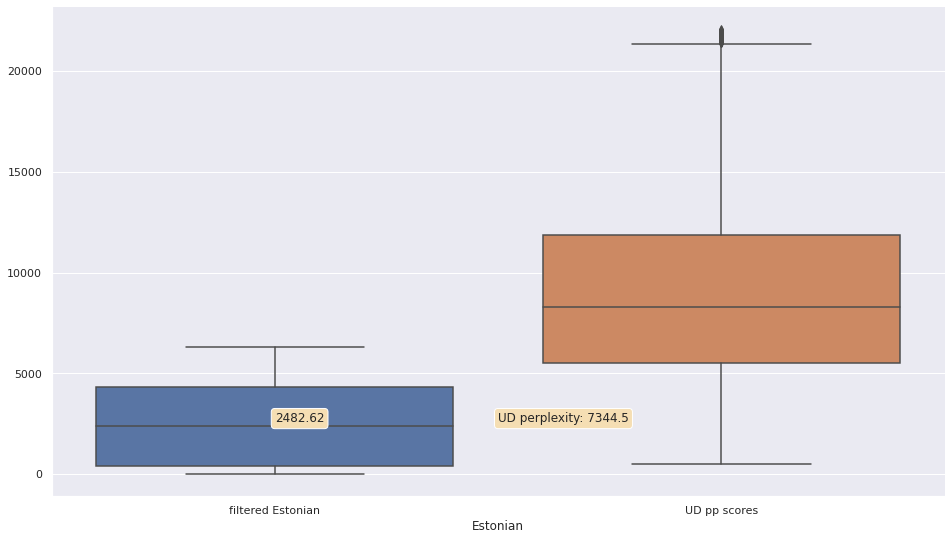

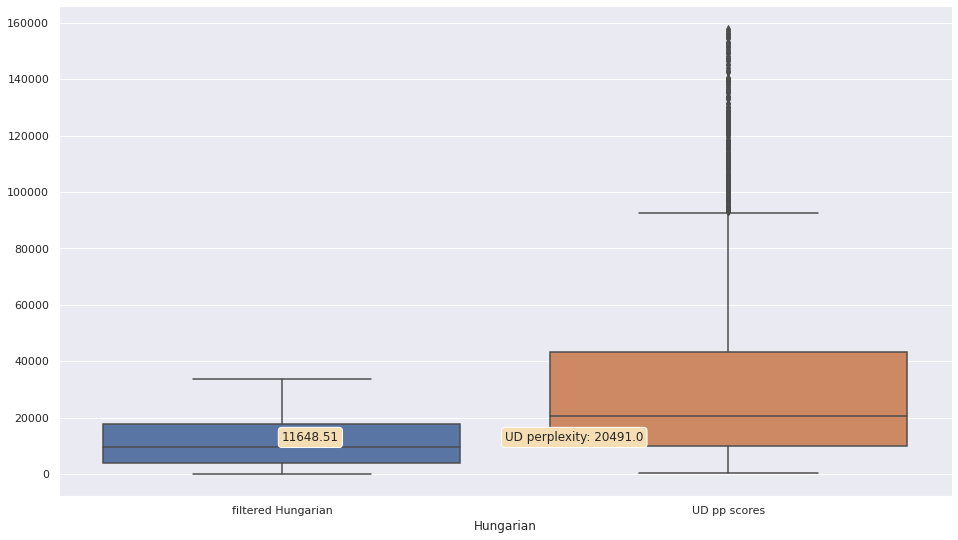

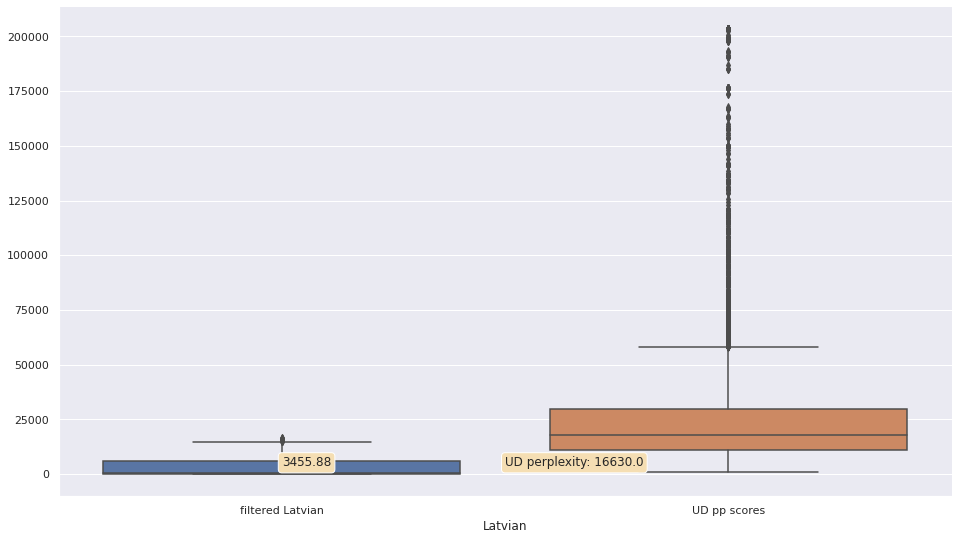

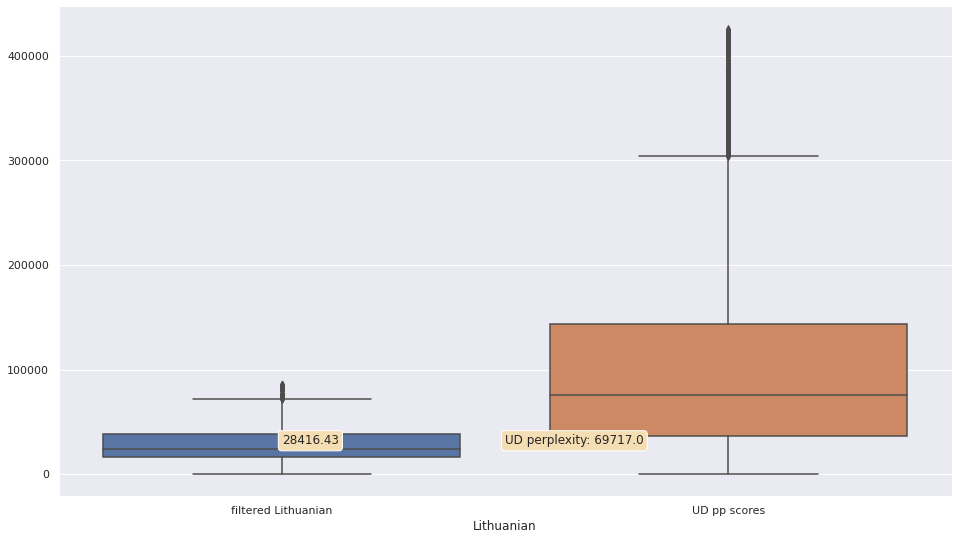

Maltese


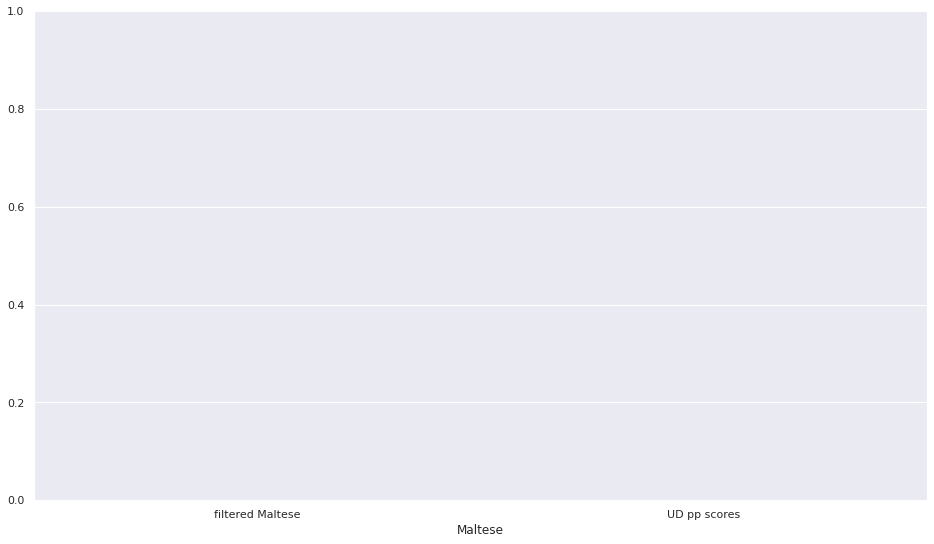

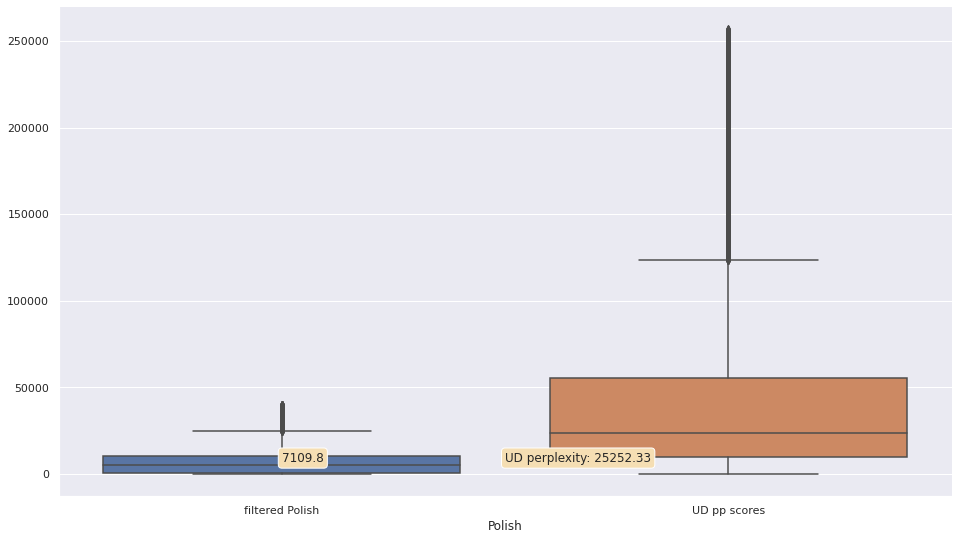

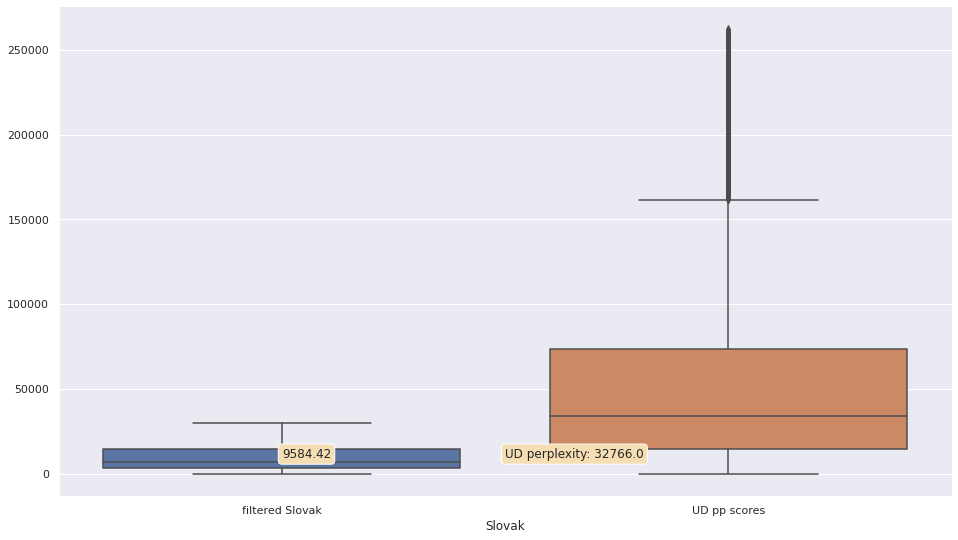

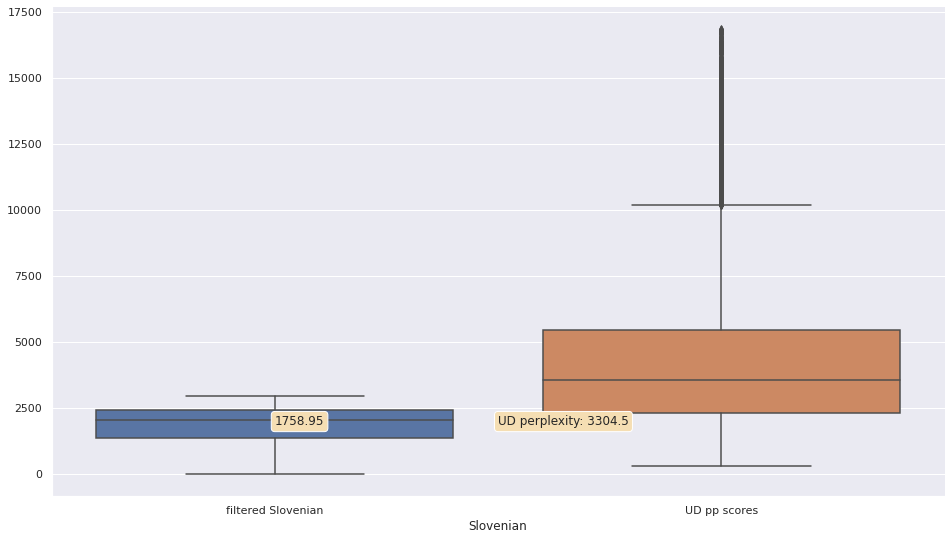

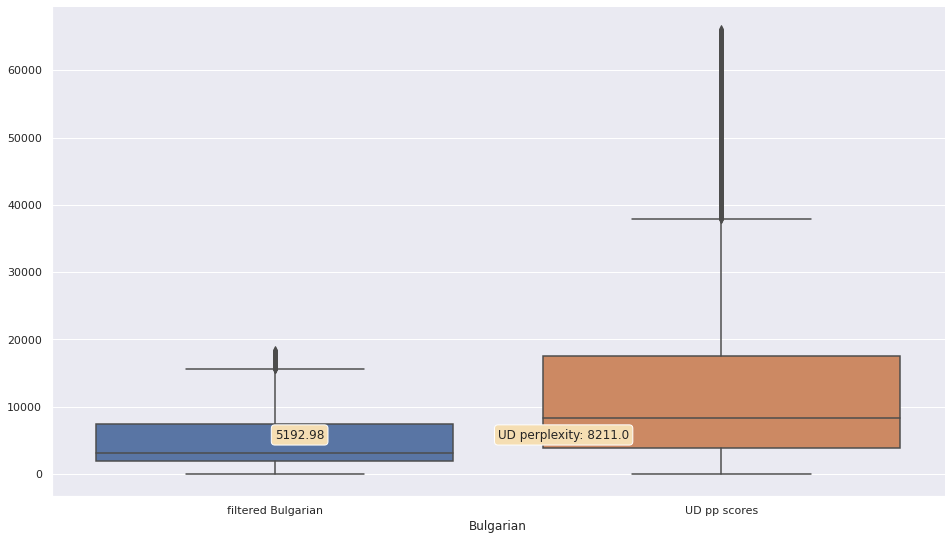

Irish


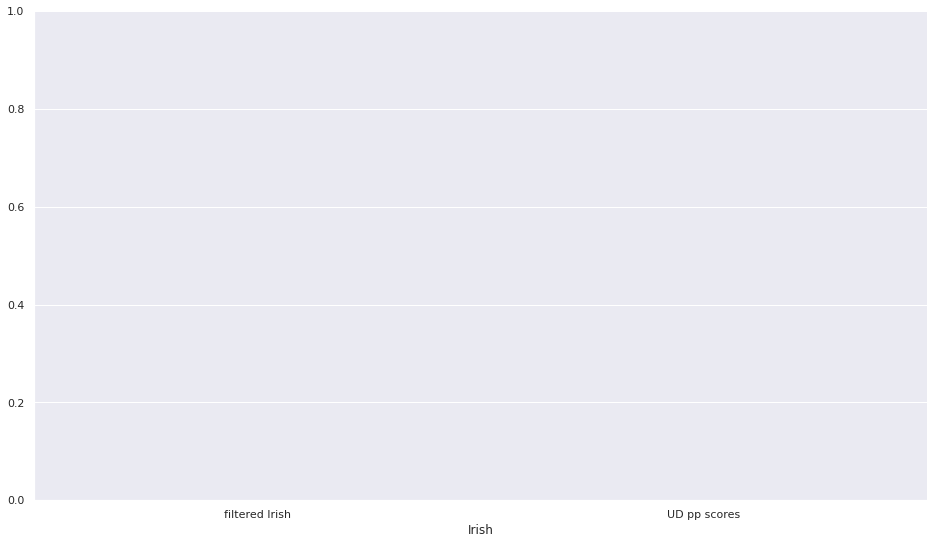

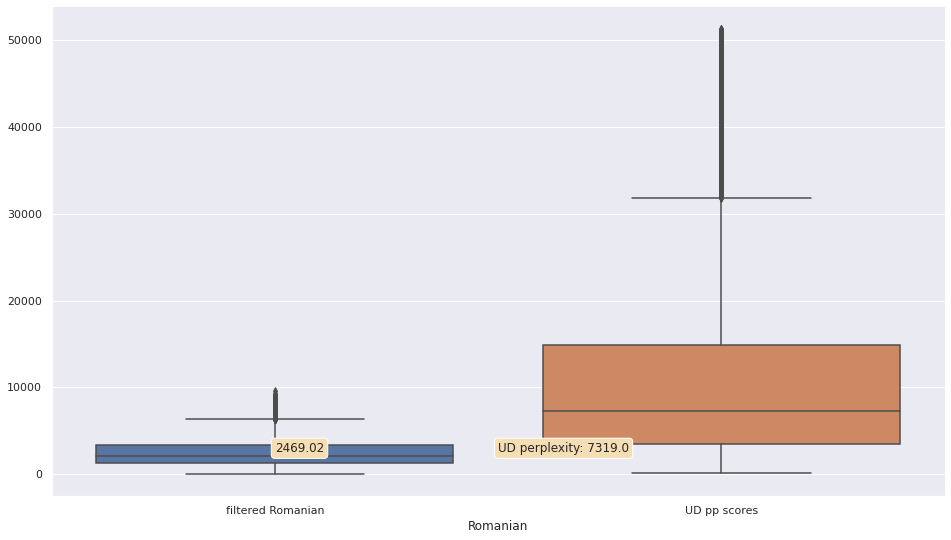

Croatian


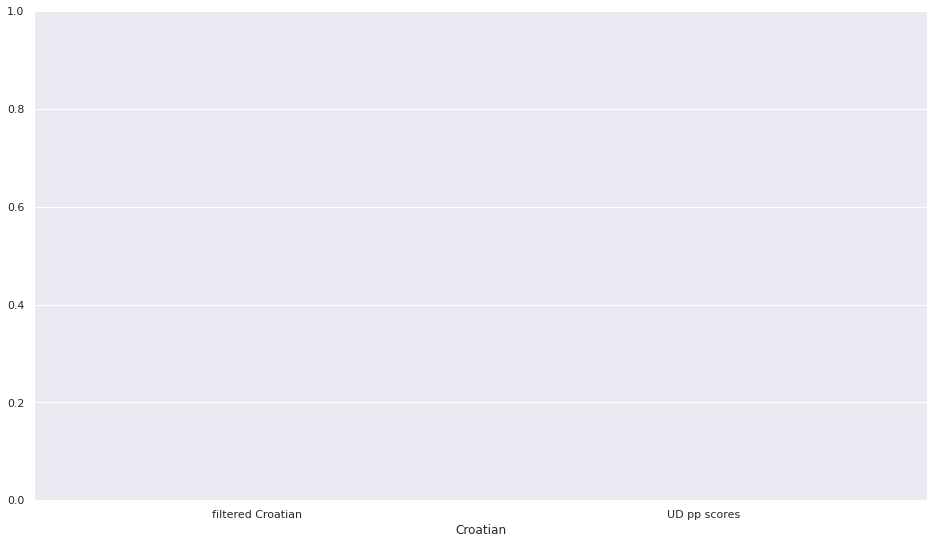

In [30]:
# textbox properties
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

for language in europe_languages:
    #  to_plot_df = pd.DataFrame({language:df[language], 'filtered '+language: filter_df[language], "UD pp scores":ffiltered_line_ud_pps[language]})
    #  to_plot_df = pd.DataFrame({language:df[language], 'filtered '+language: filter_df[language]})
    to_plot_df = pd.DataFrame({'filtered '+language: filter_df[language], "UD pp scores":ffiltered_line_ud_pps[language]})

    desc=to_plot_df.describe()
    ax = sns.boxplot(to_plot_df)
    # ax.text(0, desc[language]['mean']+1e2, round(desc[language]['mean'],2), 
    #     fontsize = 12, bbox=props) 
    try:
        ax.text(0, desc['filtered '+language]['mean']+1e2, round(desc['filtered '+language]['mean'],2), 
            fontsize = 12, bbox=props)
        ax.text(0.5, desc['filtered '+language]['mean']+1e2, "UD perplexity: "+str(final_df.loc[final_df['language']==language]['pp_score'].values[0]), 
            fontsize = 12, bbox=props) 
    except IndexError:
        print(language)

    plt.xlabel(language)
    sns.despine()
    plt.show()

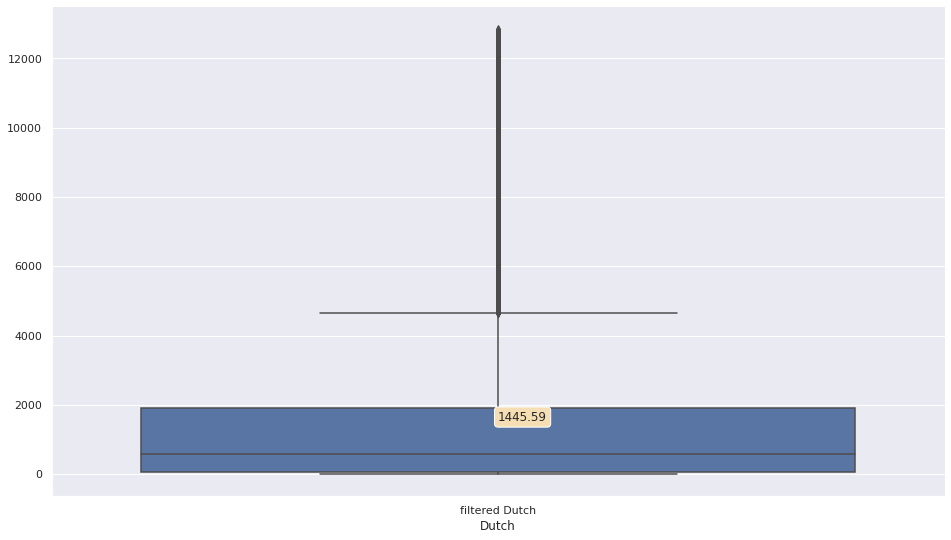

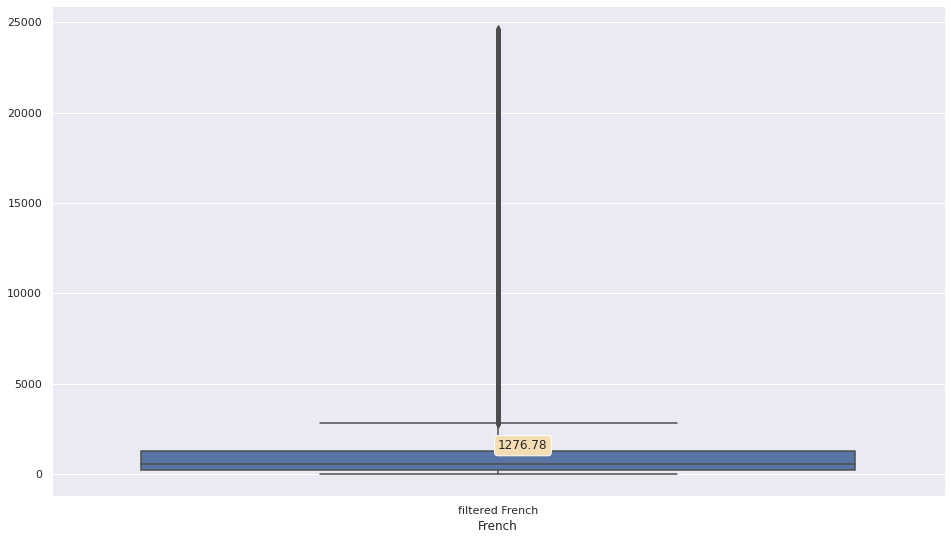

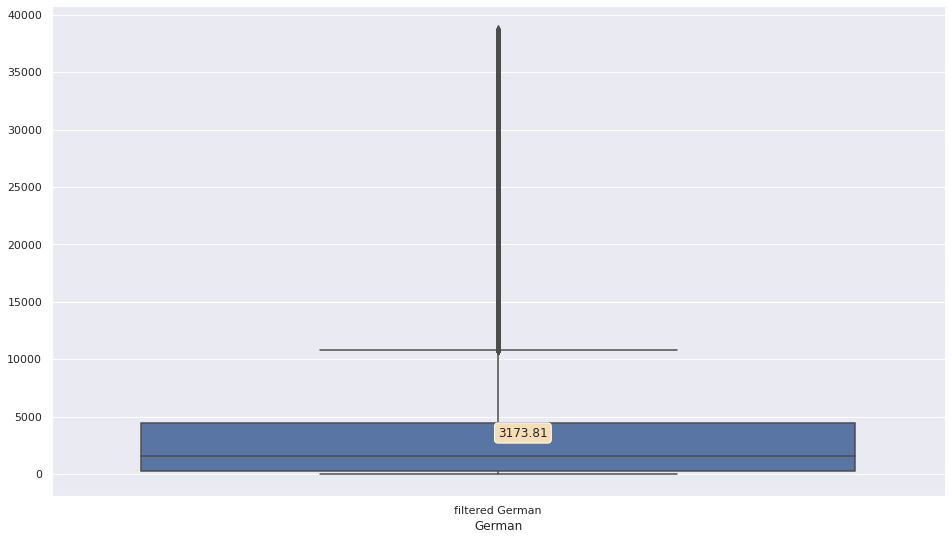

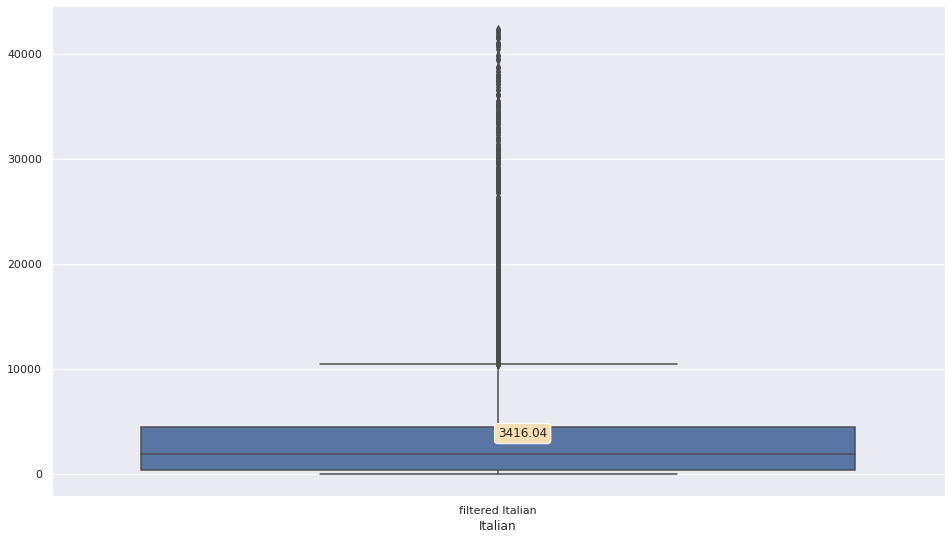

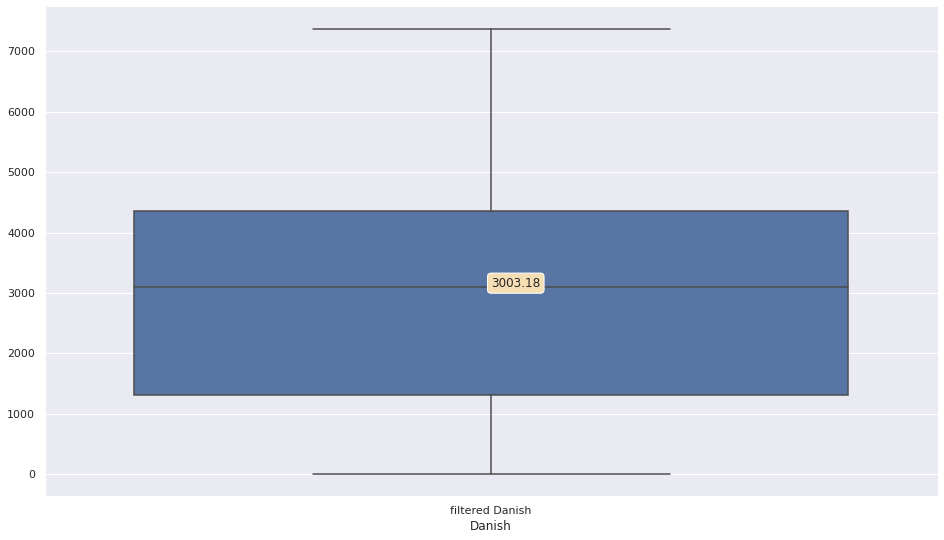

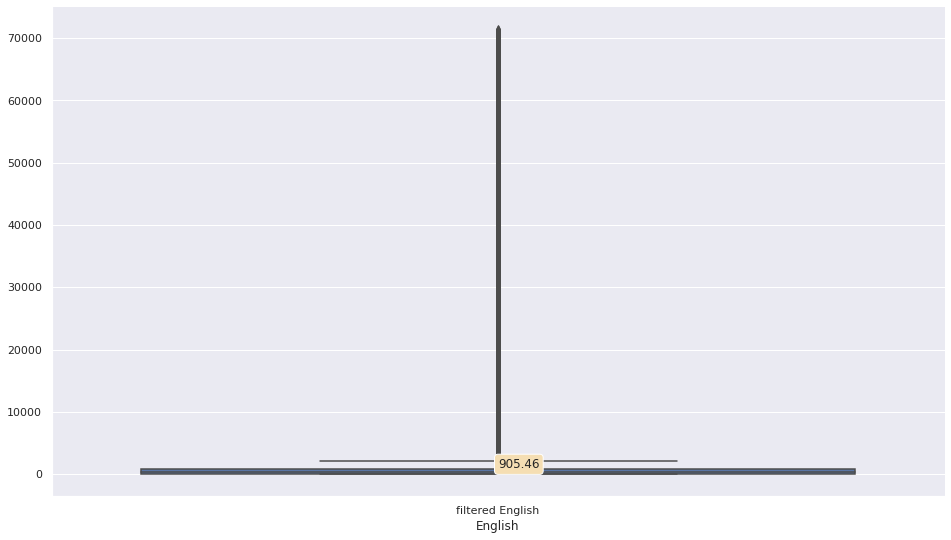

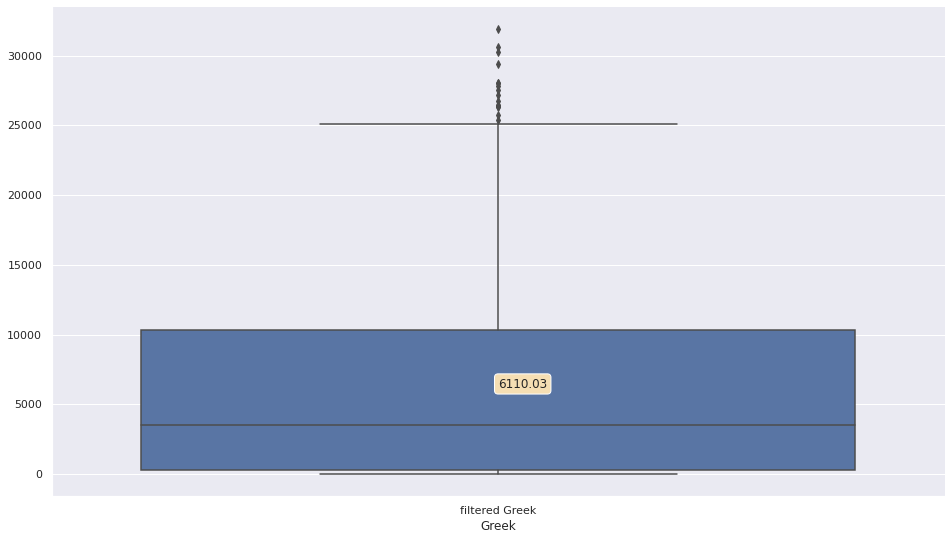

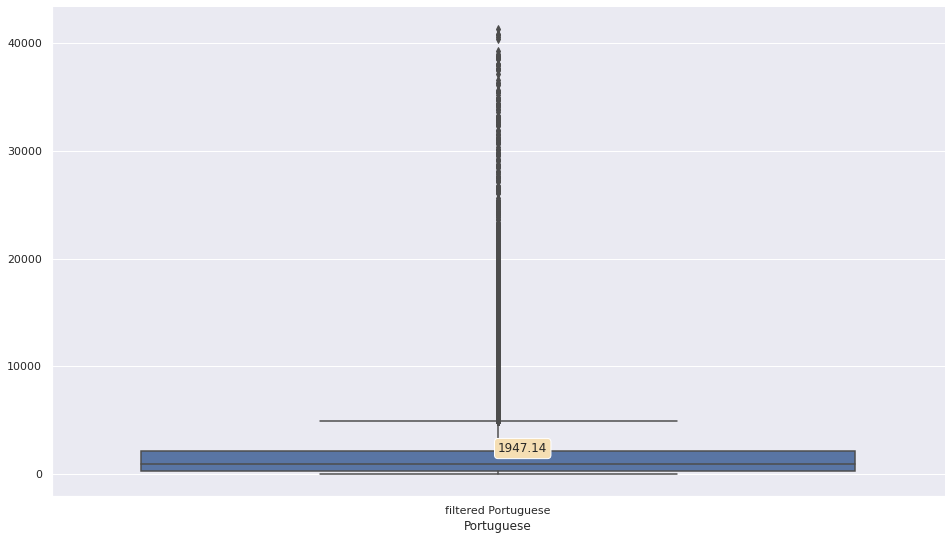

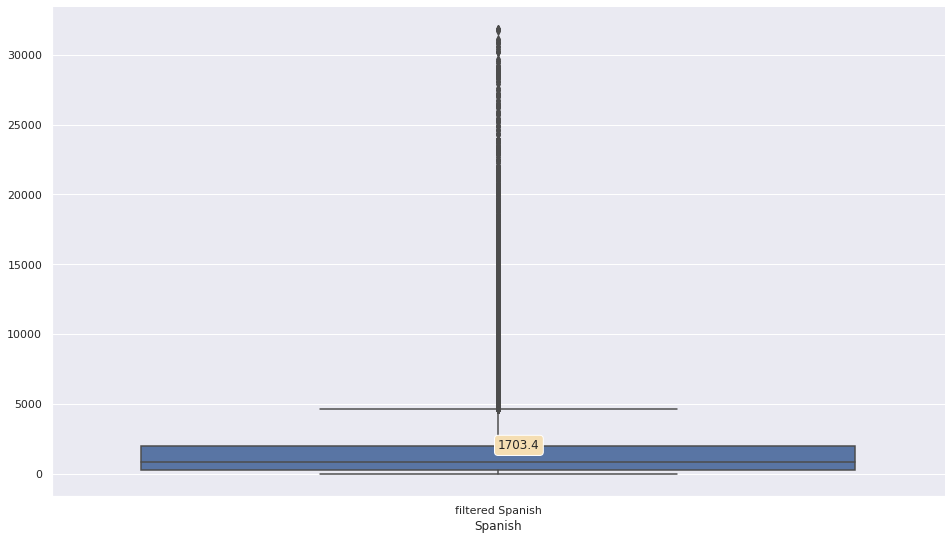

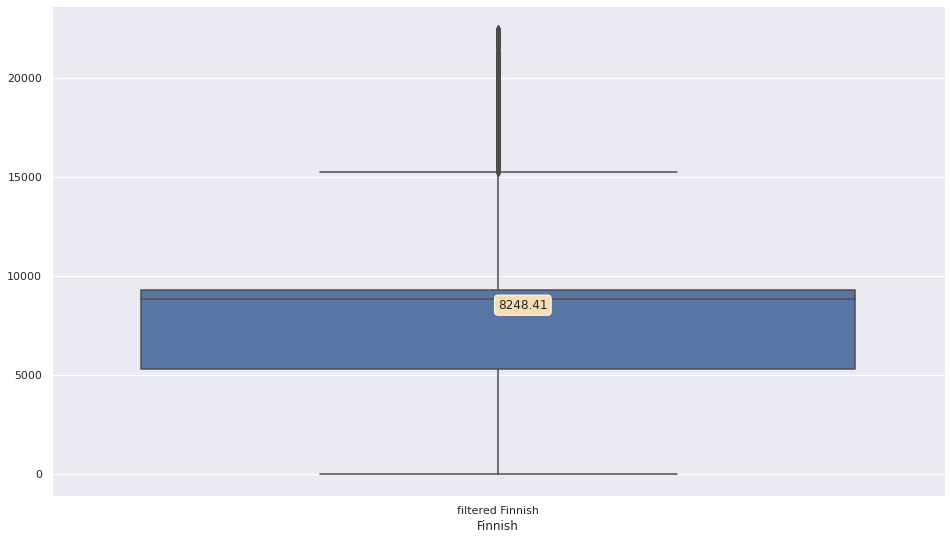

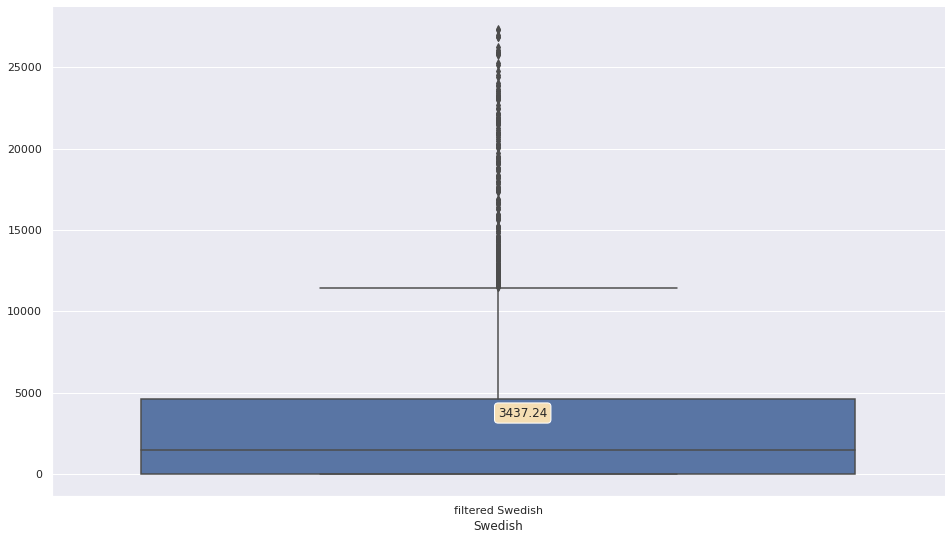

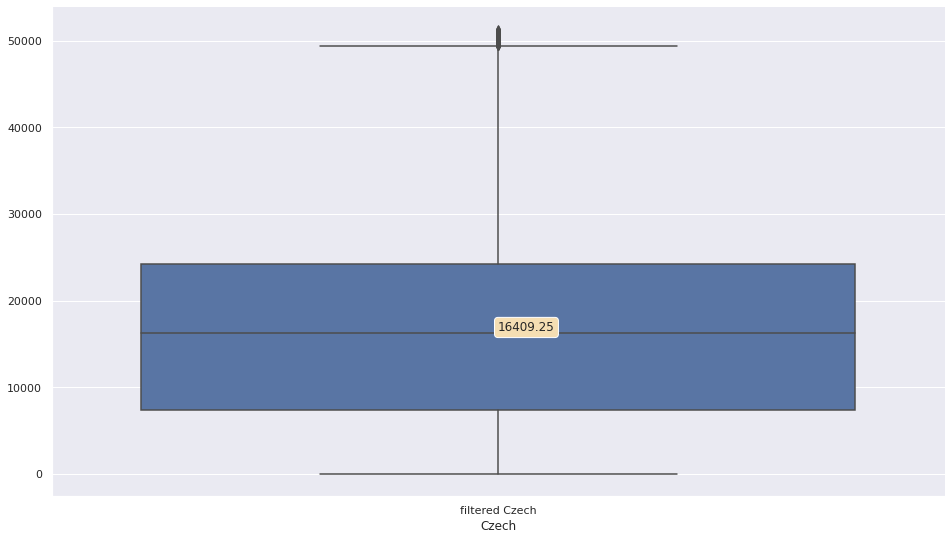

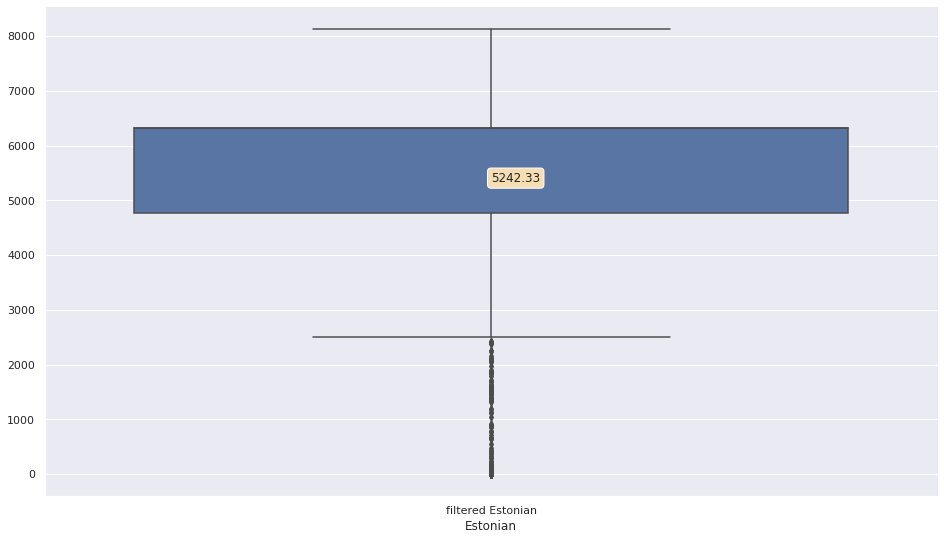

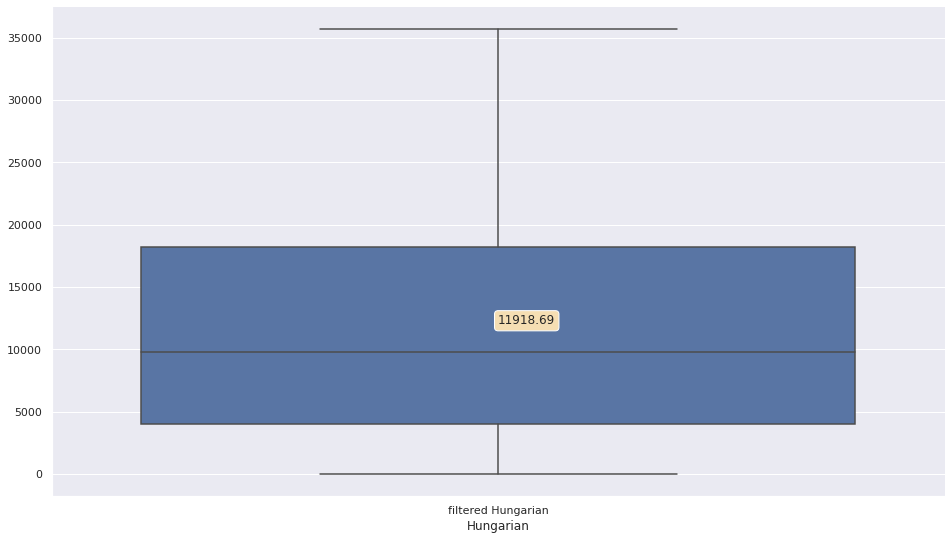

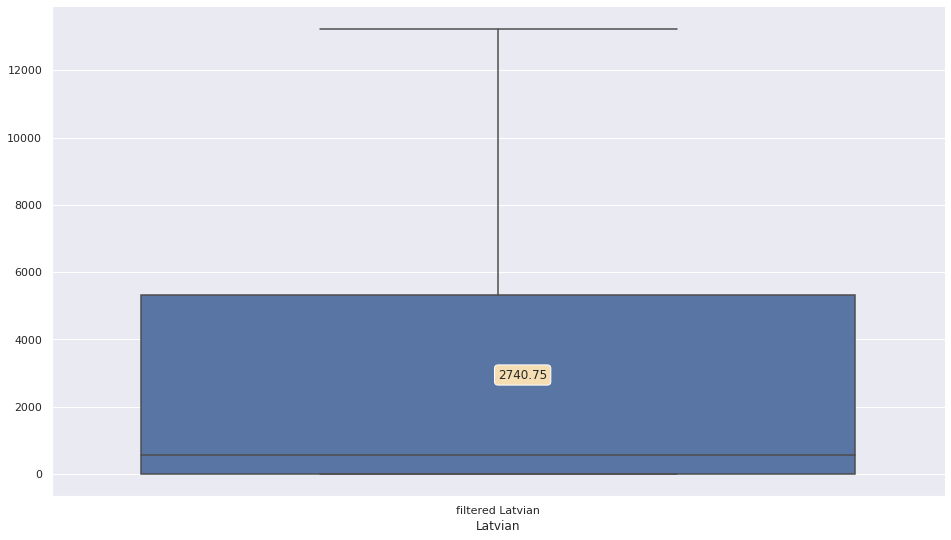

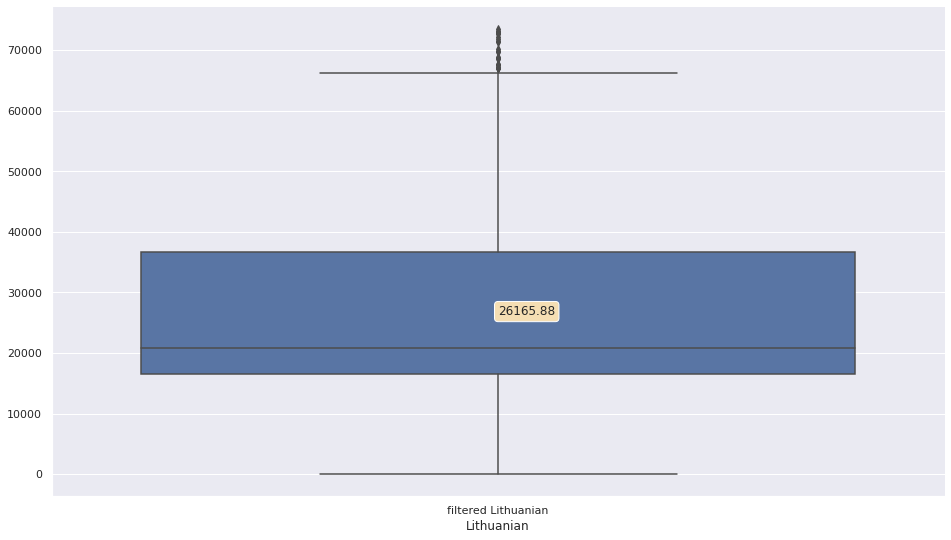

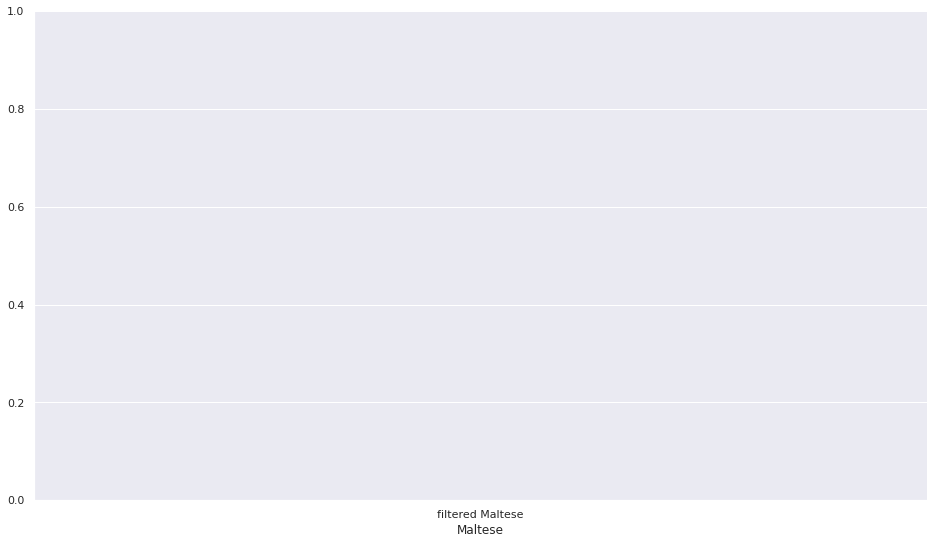

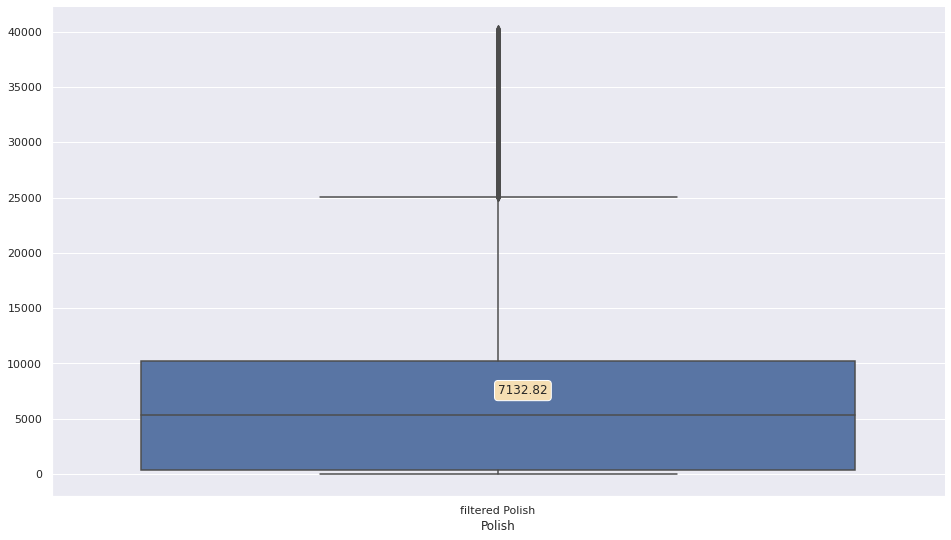

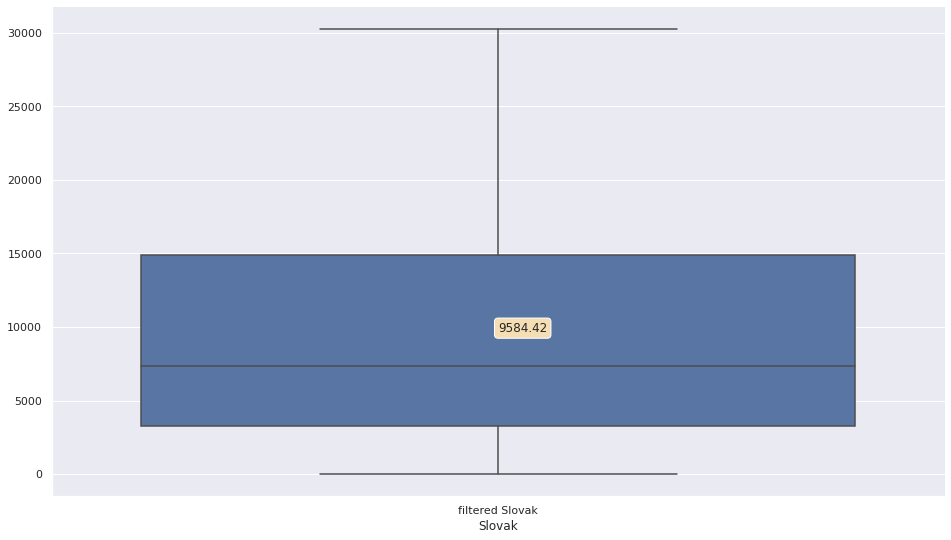

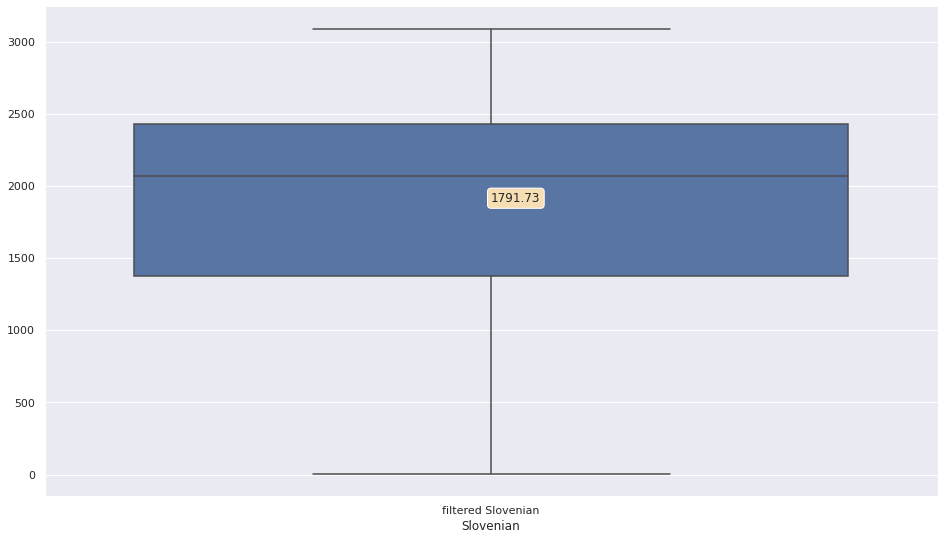

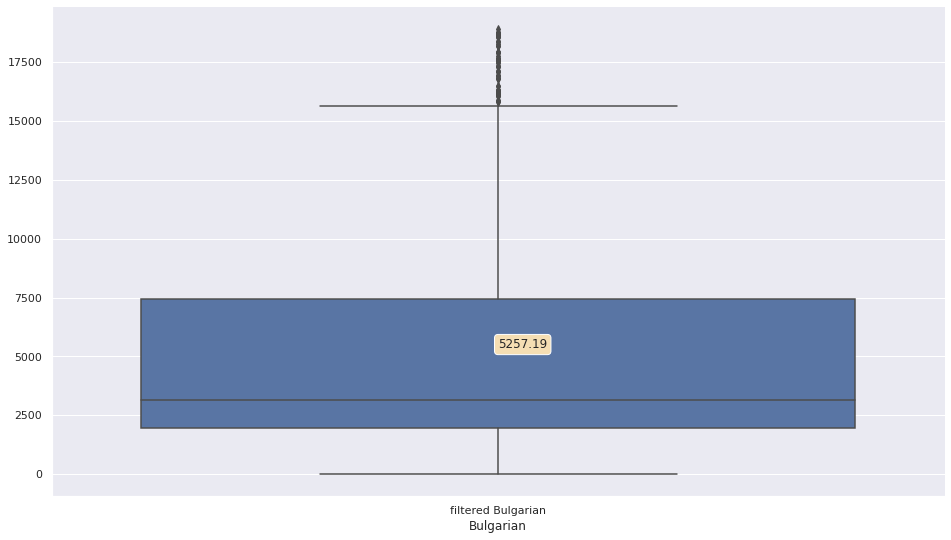

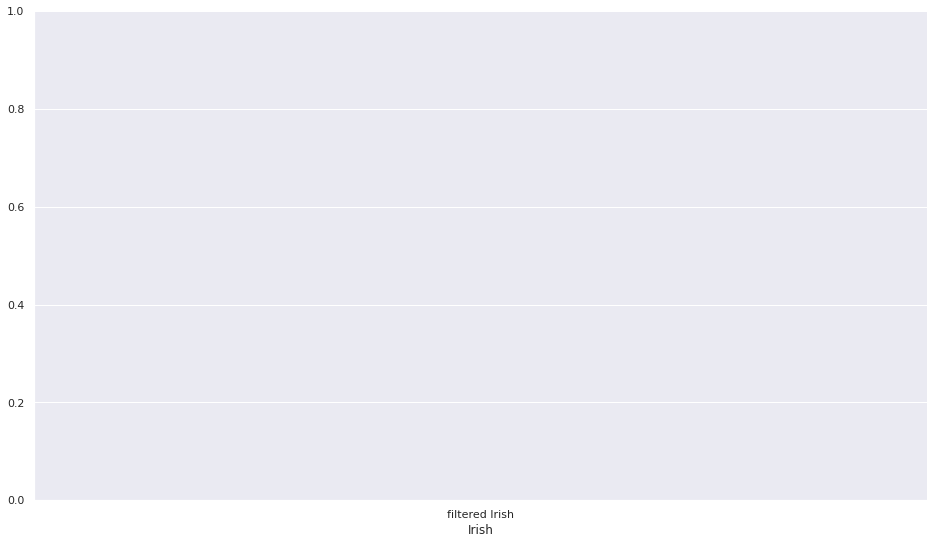

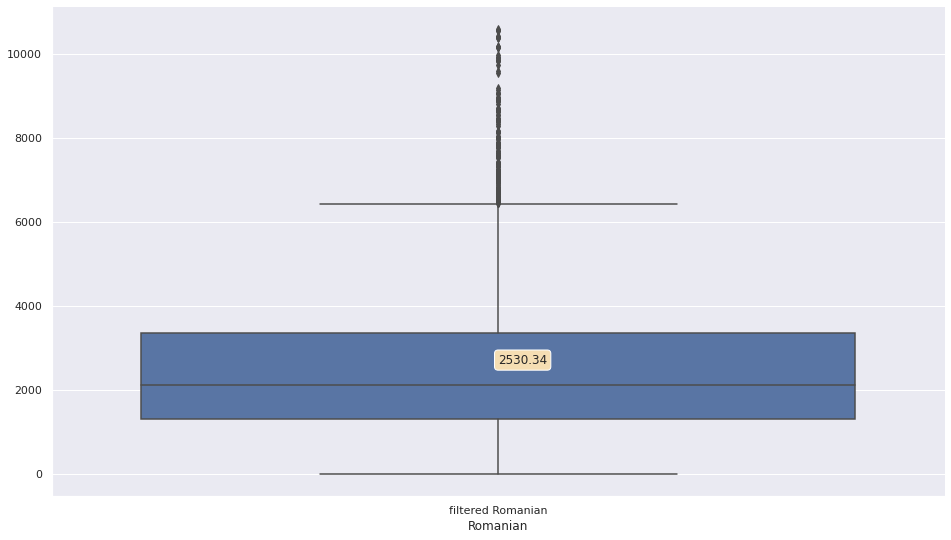

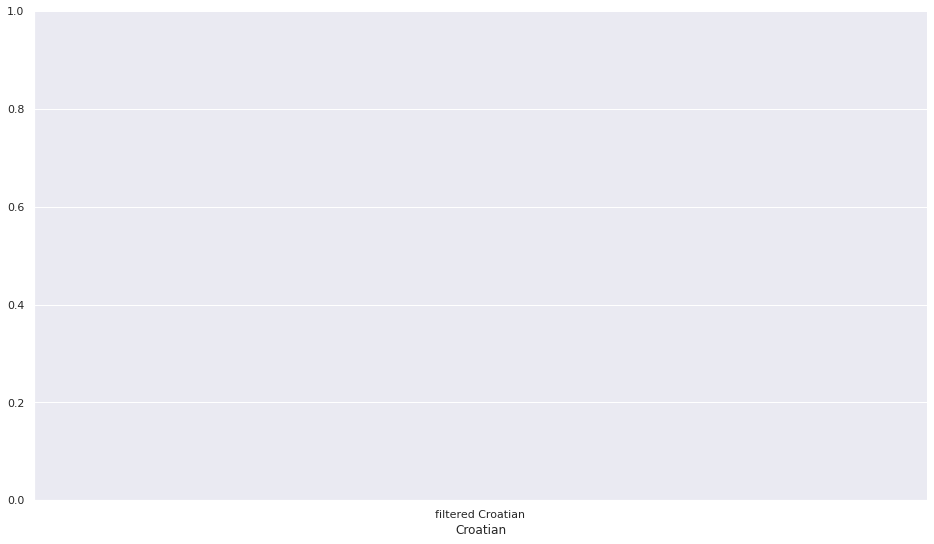

In [16]:
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

for language in europe_languages:
    to_plot_df = pd.DataFrame({'filtered '+language: filter_df[language]})
    desc=to_plot_df.describe()
    ax = sns.boxplot(to_plot_df)
    # ax.text(0, desc[language]['mean']+1e2, round(desc[language]['mean'],2), 
    #    fontsize = 12, bbox=props) # Vertical alignment 
    ax.text(0, desc['filtered '+language]['mean']+1e2, round(desc['filtered '+language]['mean'],2), 
       fontsize = 12, bbox=props) 
    plt.xlabel(language)
    sns.despine()
    plt.show()

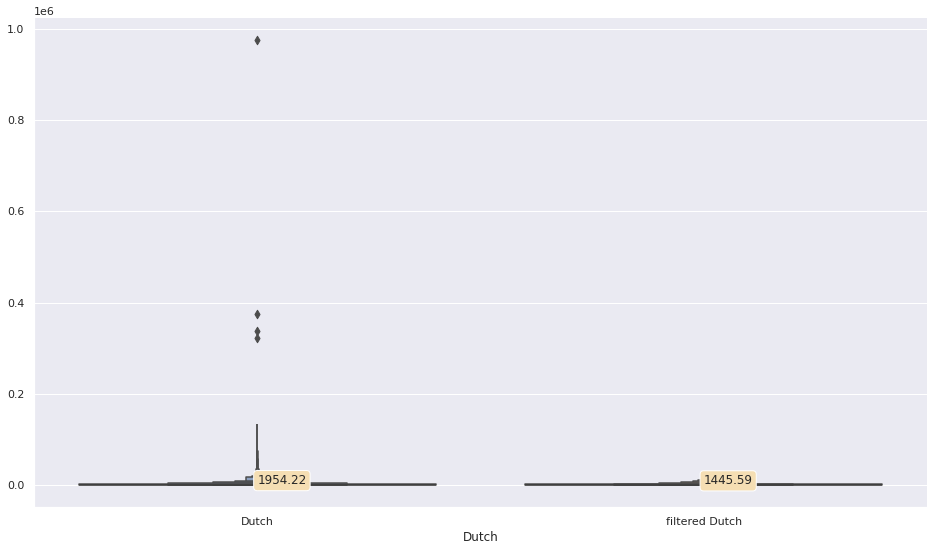

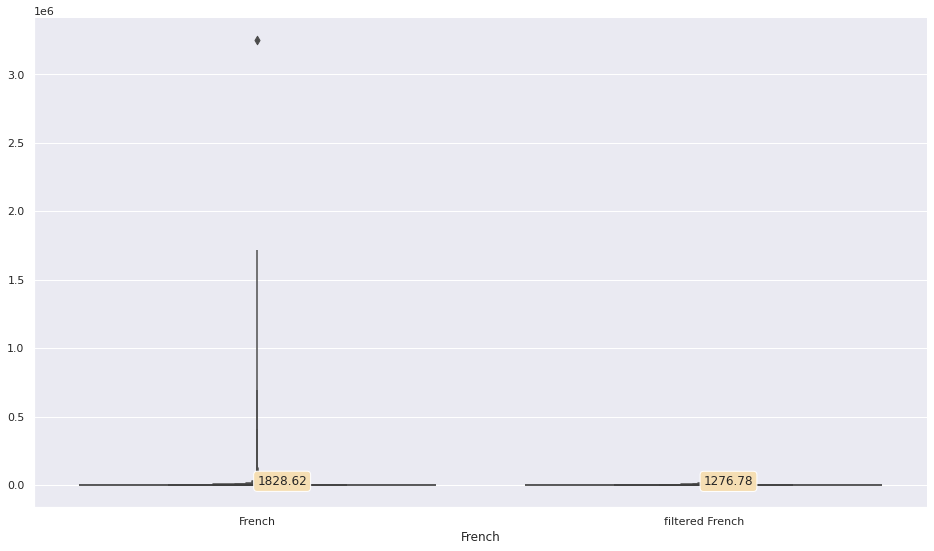

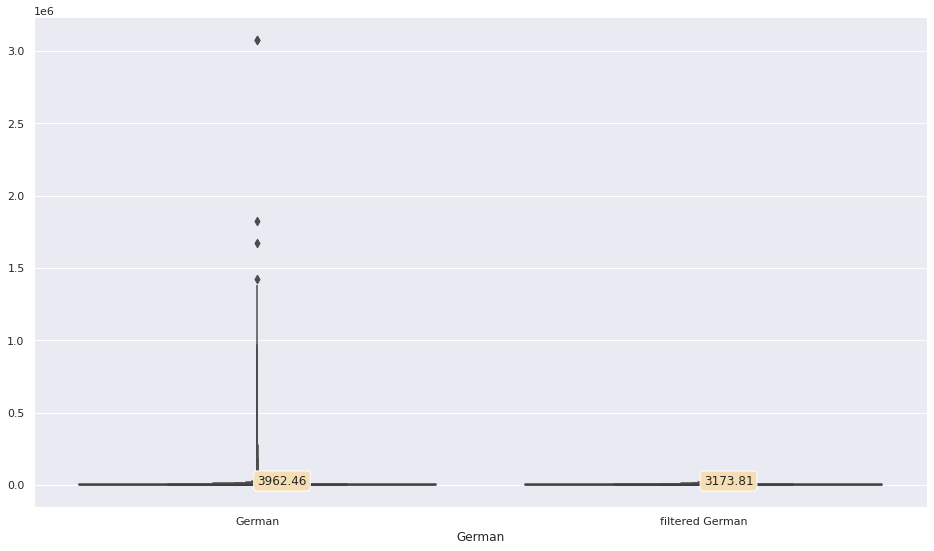

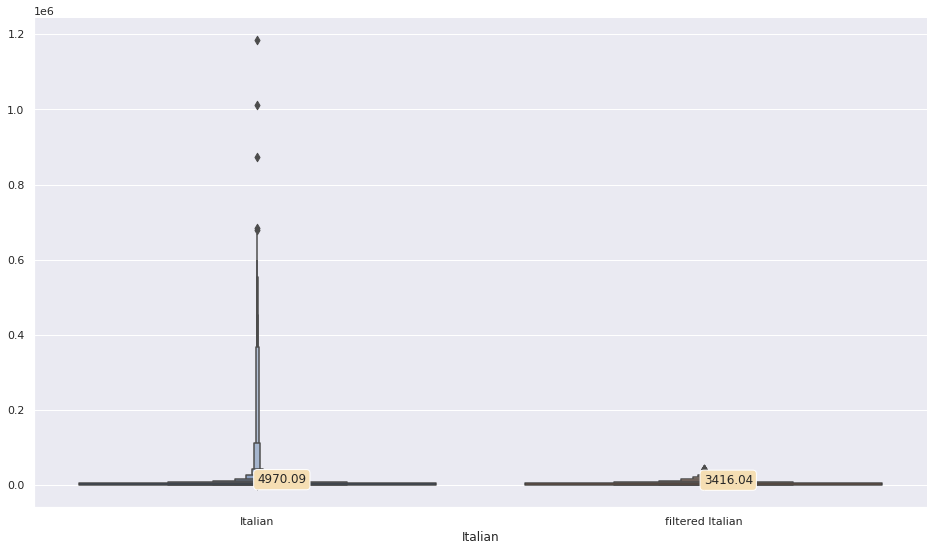

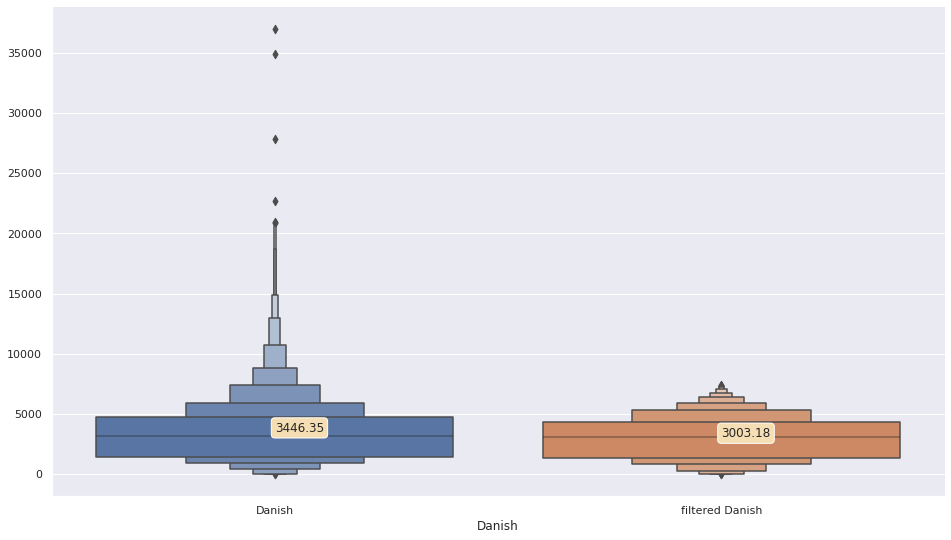

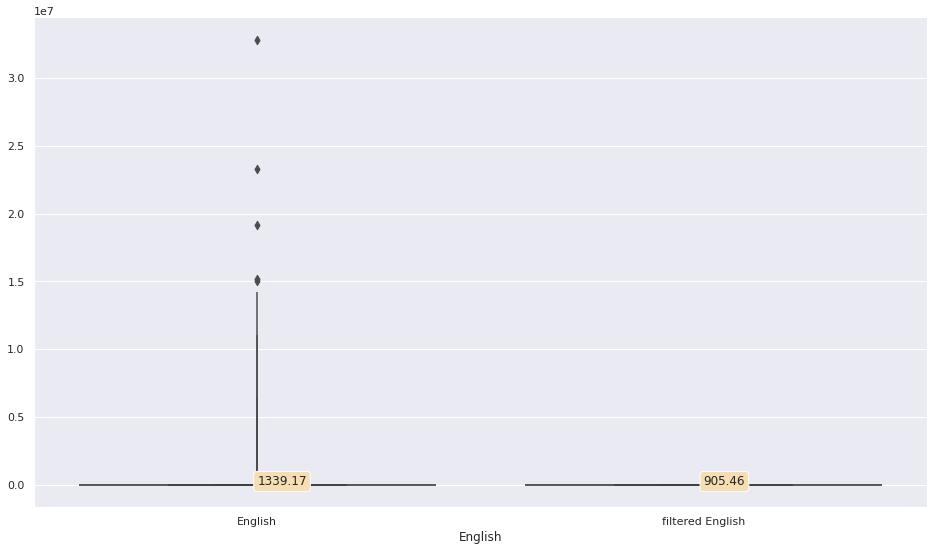

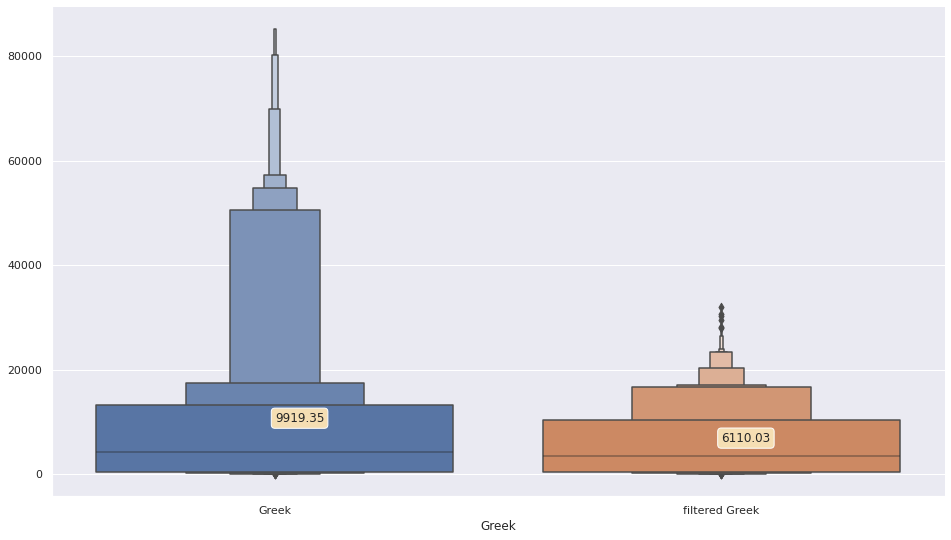

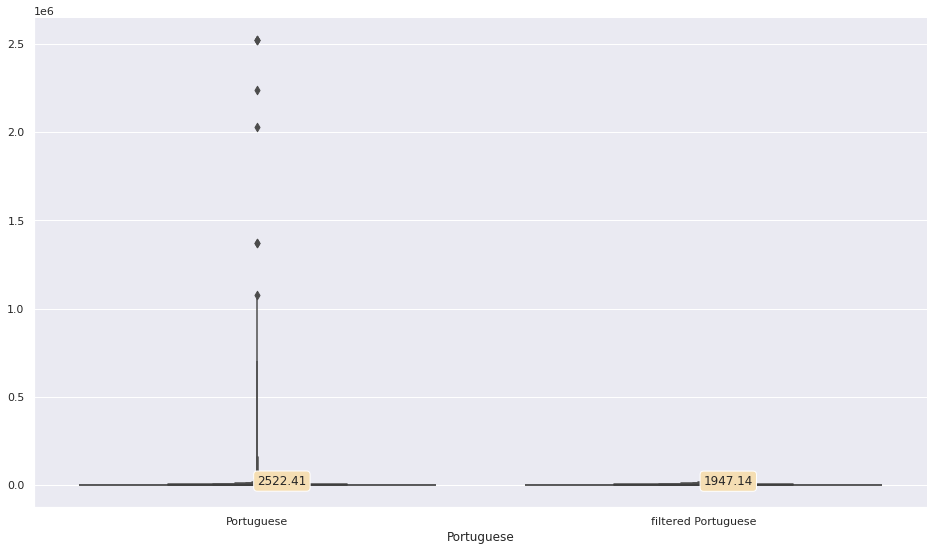

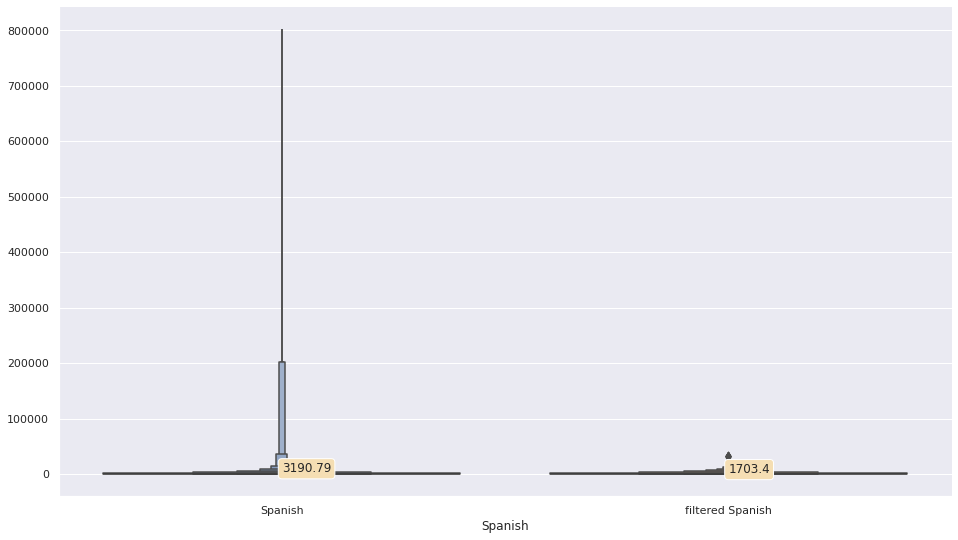

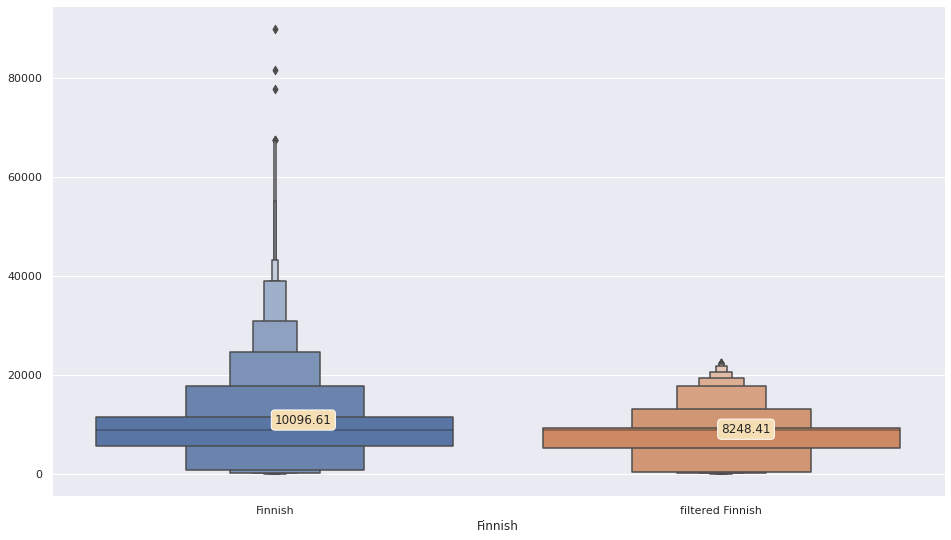

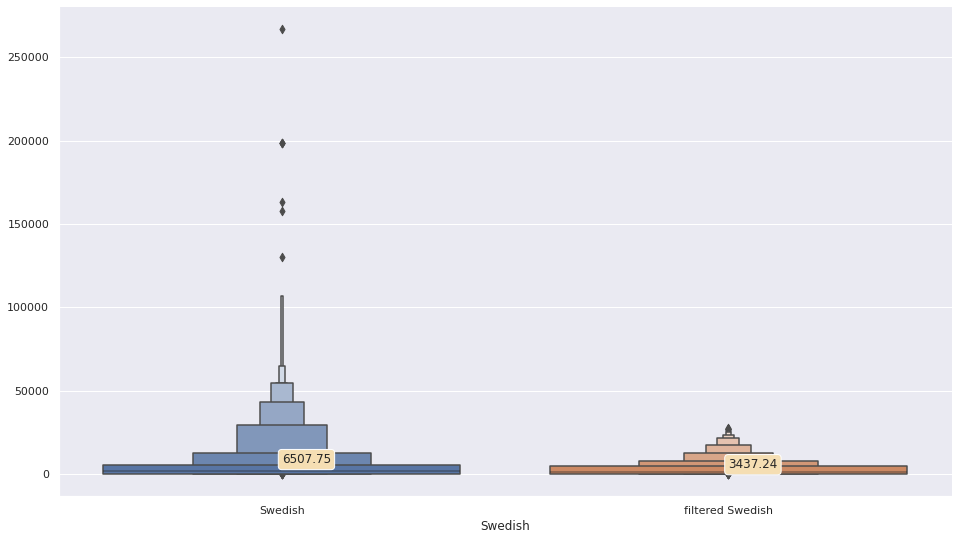

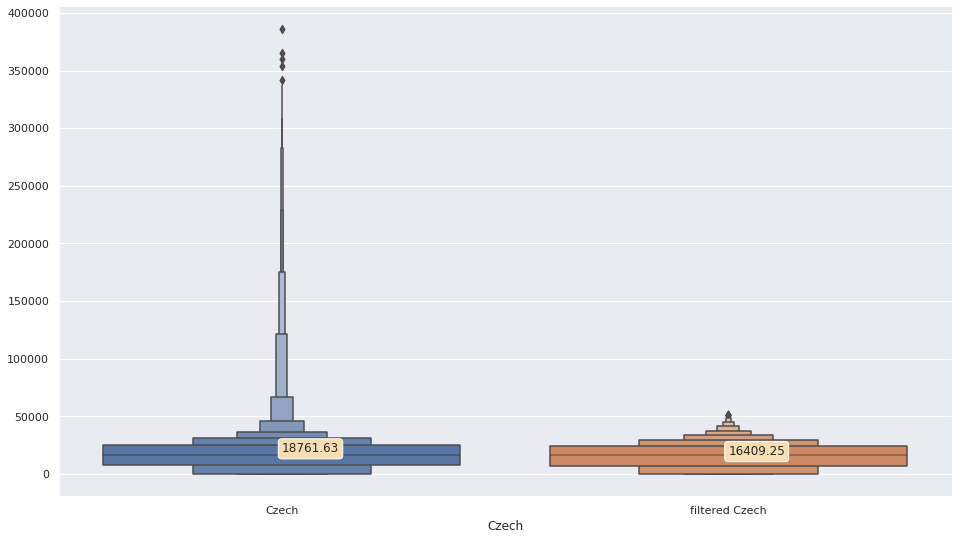

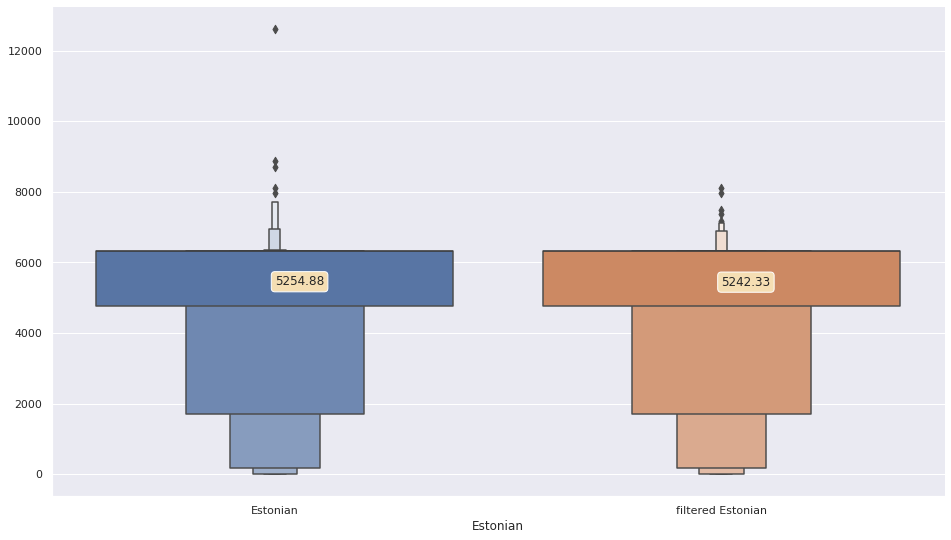

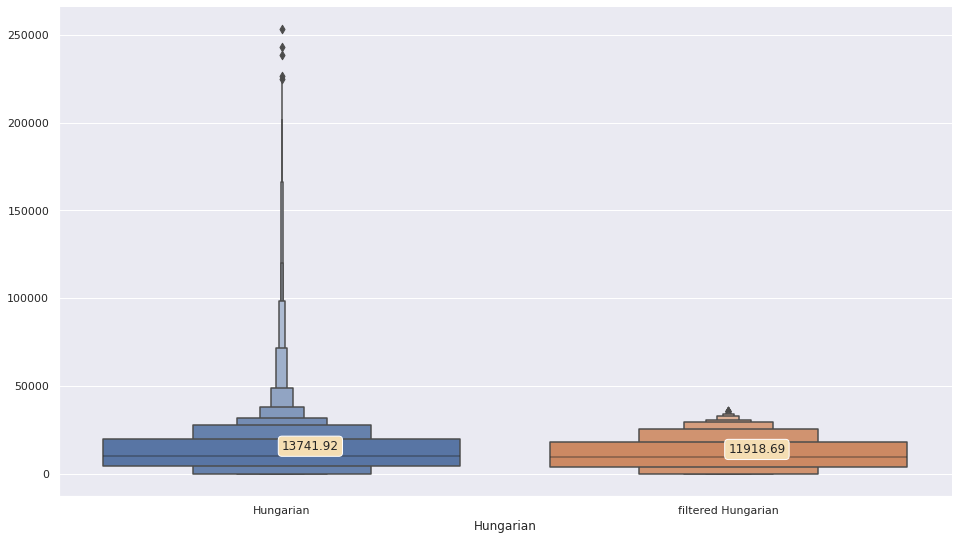

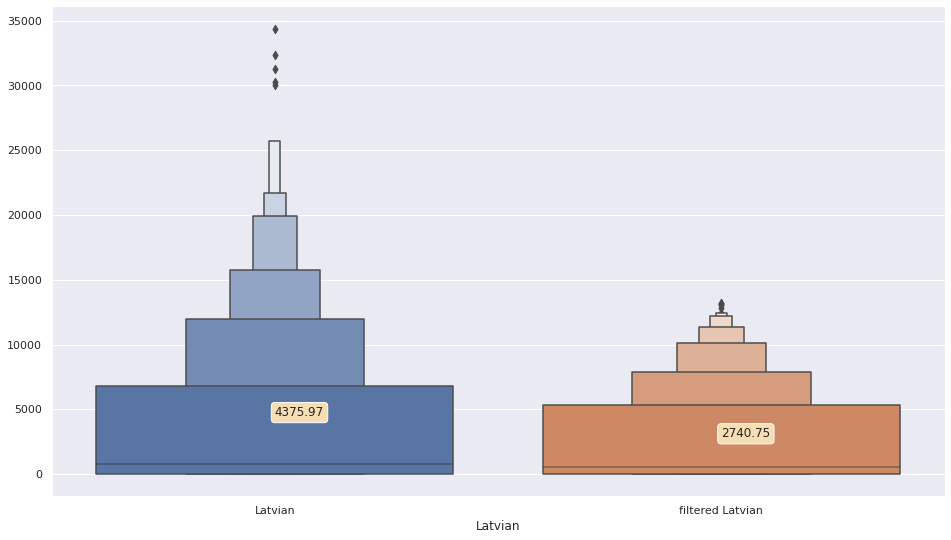

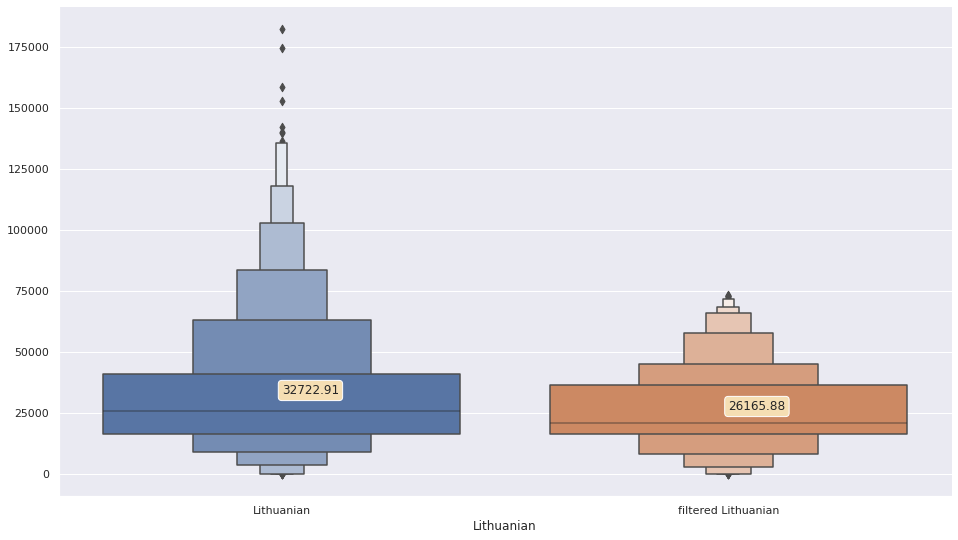

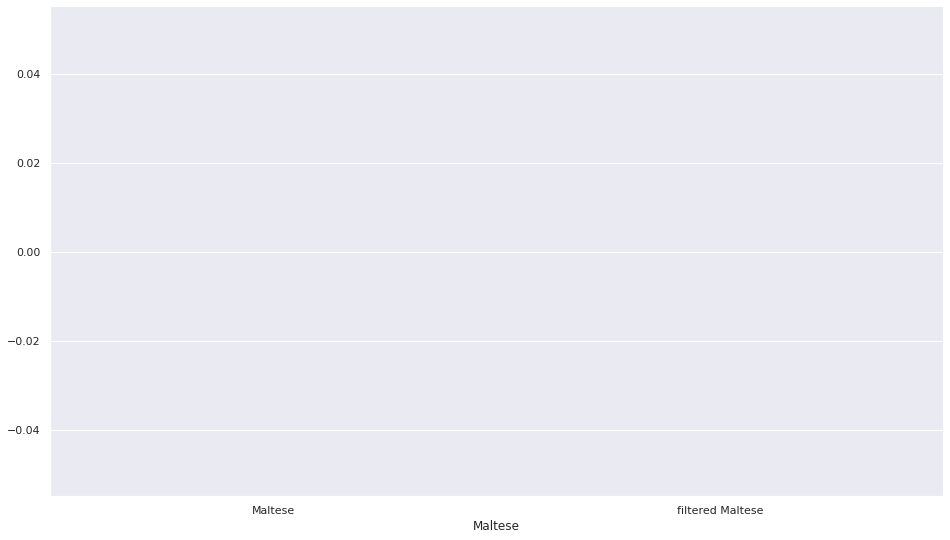

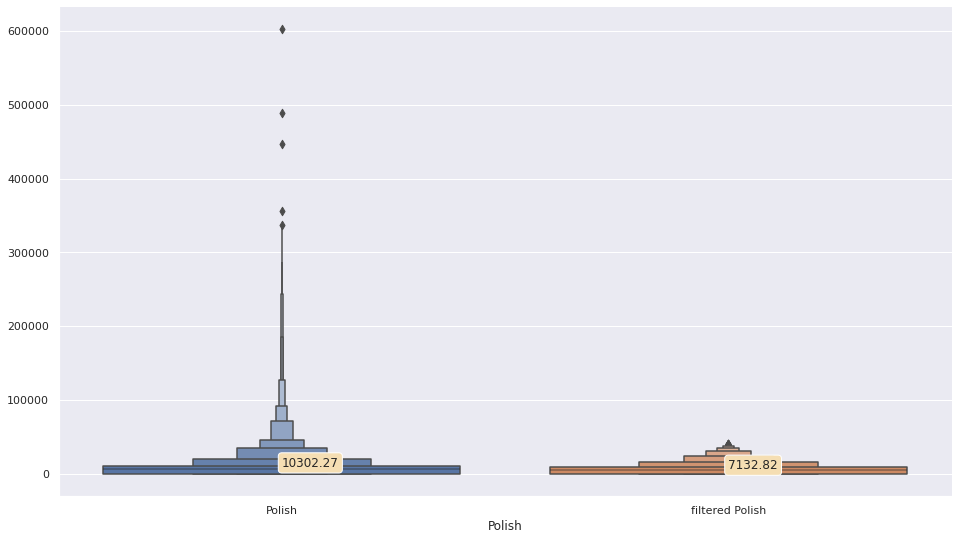

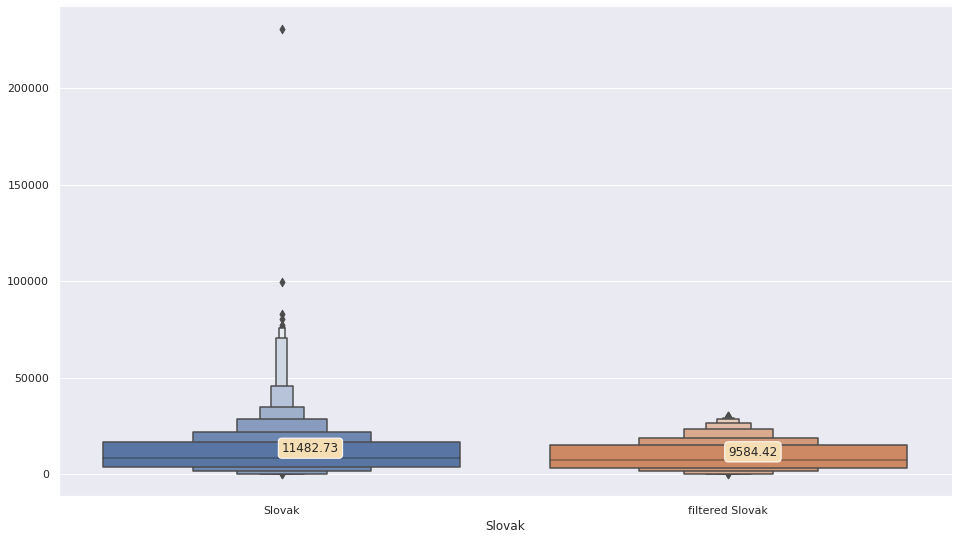

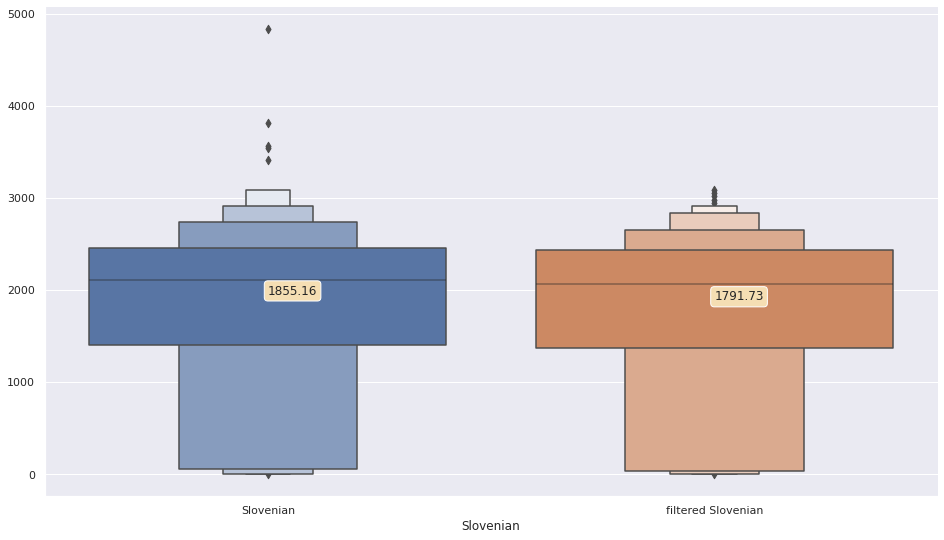

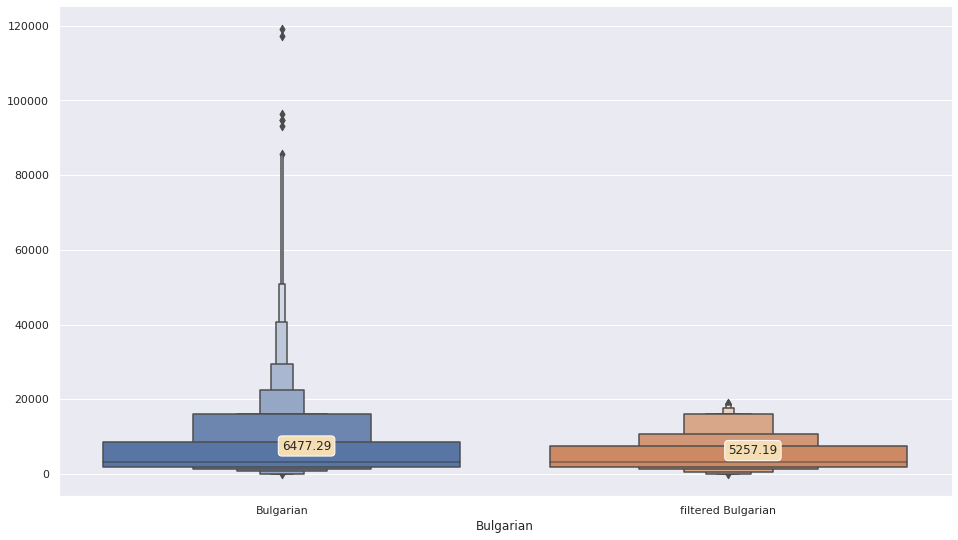

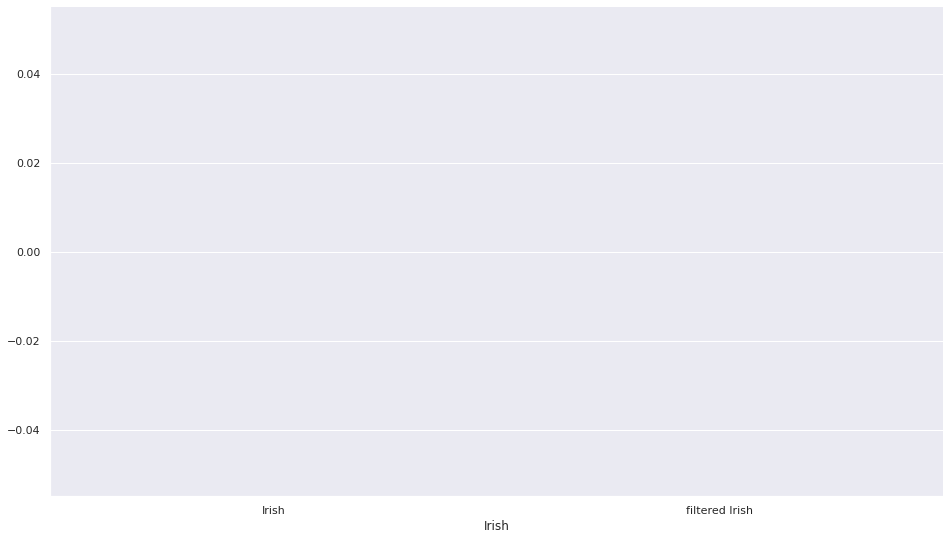

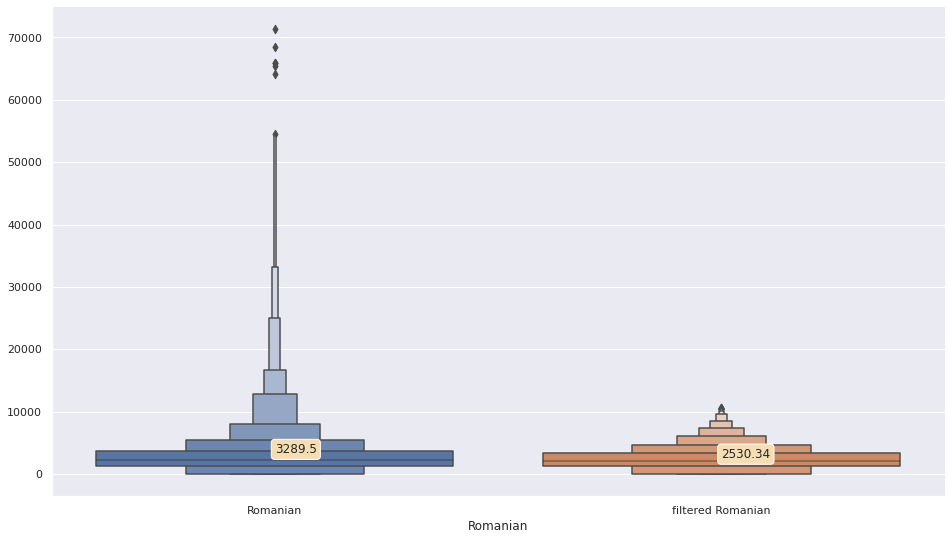

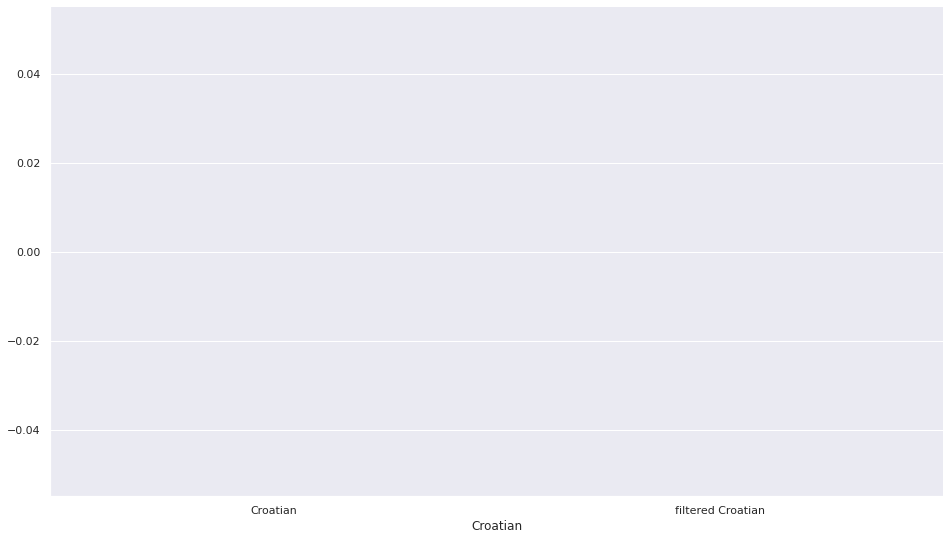

In [14]:
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

for language in europe_languages:
    to_plot_df = pd.DataFrame({language:df[language], 'filtered '+language: filter_df[language]})
    desc=to_plot_df.describe()
    ax = sns.boxenplot(to_plot_df)
    ax.text(0, desc[language]['mean']+1e2, round(desc[language]['mean'],2), 
       fontsize = 12, bbox=props) # Vertical alignment 
    ax.text(1, desc['filtered '+language]['mean']+1e2, round(desc['filtered '+language]['mean'],2), 
       fontsize = 12, bbox=props) 
    plt.xlabel(language)
    sns.despine()
    plt.show()